# Инициализация библиотек

In [56]:
import os
import random
from PIL import Image
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Часть 1: Подготовка данных

## Создание датакласса
Реализуйте собственный класс TinyImageNetDataset, наследующий от torch.utils.data.Dataset:

- Метод __init__: инициализация путей к данным, загрузка списка изображений и меток
- Метод __len__: возврат количества примеров в датасете
- Метод __getitem__: загрузка и возврат одного примера (изображение + метка)

In [226]:
import os
from PIL import Image
from torch.utils.data import Dataset


class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        root_dir: путь до папки tiny-imagenet-200
        split: 'train', 'val' или 'test'
        transform: трансформации изображений
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        # сохранение названий классов в wnids.txt
        with open(os.path.join(root_dir, 'wnids.txt'), 'r') as f:
            self.class_names = [line.strip() for line in f]
        
        #  создание поля id - классов
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}

        self.samples = []
        if split == 'train':
            train_dir = os.path.join(root_dir, 'train')
            for cls in os.listdir(train_dir):
                img_dir = os.path.join(train_dir, cls, 'images')
                if not os.path.exists(img_dir):
                    continue
                for img_name in os.listdir(img_dir):
                    img_path = os.path.join(img_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        elif split == 'val':
            val_dir = os.path.join(root_dir, 'val', 'images')
            anno_path = os.path.join(root_dir, 'val', 'val_annotations.txt')

            label_map = {}
            with open(anno_path, 'r') as f:
                for line in f:
                    img_name, cls, *_ = line.strip().split('\t')
                    label_map[img_name] = cls

            for img_name in os.listdir(val_dir):
                cls = label_map.get(img_name)
                if cls:
                    img_path = os.path.join(val_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        else:
            test_dir = os.path.join(root_dir, 'test', 'images')
            for img_name in os.listdir(test_dir):
                img_path = os.path.join(test_dir, img_name)
                self.samples.append((img_path, -1))  # тест без меток

    # возврат количества примеров в датасете
    def __len__(self):
        return len(self.samples)

    # загрузка и возврат одного примера (изображение + метка)
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')

        # преобразование изображение в соответсвии с transform
        if self.transform:
            img = self.transform(img)
        return img, label


train_transform = transforms.Compose([
    transforms.Resize((64, 64)),                    
    transforms.ToTensor(),                     
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

root = 'tiny-imagenet-200'

train_dataset = TinyImageNetDataset(root, split='train', transform=train_transform)
test_dataset = TinyImageNetDataset(root, split='val', transform=val_transform)


print(f"Train size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")
print(f"Классов: {len(train_dataset.class_names)}")

Train size: 100000
Test size: 10000
Классов: 200


**Cтратификация с помощью sklearn**
- создаем валидационную выборку из обучающей

In [229]:
all_samples = train_dataset.samples
val_fraction = 0.2

X = [x for x, y in all_samples]  # пути к изображениям
y = [y for x, y in all_samples]  # метки классов

print(f" Подготовлено {len(X)} образцов с {len(set(y))} классами")

sss = StratifiedShuffleSplit(n_splits=1, test_size=val_fraction, random_state=42)
train_idx, val_idx = next(sss.split(X, y))

# Создаем стратифицированные разделения
train_split_stratified = [all_samples[i] for i in train_idx]
val_split_stratified = [all_samples[i] for i in val_idx]

print(f" Стратифицированное разделение:")
print(f"   Train: {len(train_split_stratified)} образцов")
print(f"   Val: {len(val_split_stratified)} образцов")


 Подготовлено 100000 образцов с 200 классами
 Стратифицированное разделение:
   Train: 80000 образцов
   Val: 20000 образцов


**Выделяем 10 классов из датасета**

In [230]:
class CustomDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

In [259]:
selected_classes = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27]  # 10 классов

train_subset_samples = [s for s in train_split_stratified if s[1] in selected_classes]
val_subset_samples = [s for s in val_split_stratified if s[1] in selected_classes]
test_subset_samples = [s for s in test_dataset.samples if s[1] in selected_classes]

# Переопределяем классы чтобы не было проблем с обучением 
class_to_new_idx = {cls: i for i, cls in enumerate(selected_classes)}

def remap_samples(samples):
    return [(path, class_to_new_idx[label]) for path, label in samples]

train_subset_samples = remap_samples(train_subset_samples)
val_subset_samples = remap_samples(val_subset_samples)
test_subset_samples = remap_samples(test_subset_samples)

train_subset_dataset = CustomDataset(train_subset_samples, transform=train_transform)
val_subset_dataset = CustomDataset(val_subset_samples, transform=val_transform)
test_subset_dataset = CustomDataset(test_subset_samples, transform=val_transform)

train_loader = DataLoader(train_subset_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_subset_dataset, batch_size=len(test_subset_dataset), shuffle=False)


print(f'Всего классов : {len(selected_classes)}')
print(f'Обьем обучающей выборки : {len(train_subset_samples)}')
print(f'Обьем валидационной выборки : {len(val_subset_samples)}')
print(f'Обьем тестовой выборки : {len(test_subset_samples)}')

Всего классов : 10
Обьем обучающей выборки : 4000
Обьем валидационной выборки : 1000
Обьем тестовой выборки : 500


# Часть 2: Базовая архитектура ResNet18

## 2.1. Реализация Basic Block

In [61]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_chanels, stride = 1, activation = 'relu'):
        super().__init__()

        self.conv_1 = nn.Conv2d(in_channels= in_channels, out_channels=out_chanels, kernel_size= 3, padding=1, stride=stride, bias=False)
        self.bn_1 = nn.BatchNorm2d(out_chanels)

        self.conv_2 = nn.Conv2d(in_channels= out_chanels, out_channels= out_chanels, kernel_size= 3, padding= 1, stride= 1, bias=False)
        self.bn_2 = nn.BatchNorm2d(out_chanels)

        # Выбор функции активации
        if activation == 'relu':
            self.activation = nn.ReLU(inplace=True)
        elif activation == 'leakyrelu':
            self.activation = nn.LeakyReLU(inplace=True)
        elif activation == 'elu':
            self.activation = nn.ELU(inplace=True)
        elif activation == 'gelu':
            self.activation = nn.GELU()

        self.downsample = nn.Identity()

        if in_channels != out_chanels or stride != 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels= out_chanels, kernel_size=1, padding=0, stride = stride, bias=False),
                nn.BatchNorm2d(out_chanels)
            )

    def forward(self, x):

        x_0 = self.downsample(x)

        x = self.activation(self.bn_1(self.conv_1(x)))
        x = self.bn_2(self.conv_2(x))

        # Skip connection
        x += x_0
        x = self.activation(x)

        return x
    
basic_block = BasicBlock(3, 128, stride=2)
test_tensor = torch.randn(1, 3, 64, 64)

print(basic_block(test_tensor).shape)

torch.Size([1, 128, 32, 32])


## 2.2. Реализация ResNet18

In [62]:
class SimpleResNet18(nn.Module):
    def __init__(self, num_classes = 10):
        super().__init__()

        self.conv = nn.Conv2d(in_channels=3,out_channels= 64, kernel_size=3, stride=1, bias=False)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.basic_block_1_1 = BasicBlock(64, 64) # [64, 64, 64]
        self.basic_block_1_2 = BasicBlock(64, 64) # [64, 64, 64]

        self.basic_block_2_1 = BasicBlock(64, 128, stride = 2) # [128, 32, 32]
        self.basic_block_2_2 = BasicBlock(128, 128) # [128, 32, 32]

        self.basic_block_3_1 = BasicBlock(128, 256, stride = 2) # [256, 16, 16]
        self.basic_block_3_2 = BasicBlock(256, 256) # [256, 16, 16]

        self.basic_block_4_1 = BasicBlock(256, 512, stride = 2) # [512, 8, 8]
        self.basic_block_4_2 = BasicBlock(512, 512) # [512, 8, 8]

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

        self.fc = nn.Linear(in_features=512, out_features=num_classes)
    
    def forward(self, x):
        x = self.relu(self.bn(self.conv(x)))
        
        x = self.basic_block_1_1(x)
        x = self.basic_block_1_2(x)

        x = self.basic_block_2_1(x)
        x = self.basic_block_2_2(x)

        x = self.basic_block_3_1(x)
        x = self.basic_block_3_2(x)

        x = self.basic_block_4_1(x)
        x = self.basic_block_4_2(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)

        x = self.fc(x)

        return x


model = SimpleResNet18(num_classes=10)
test_tensor = torch.randn(1, 3, 64, 64)
print(model(test_tensor).shape)

torch.Size([1, 10])


## 2.3 Количество параметров

In [63]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f" Всего параметров: {total_params:,}")
print(f" Обучаемых параметров: {trainable_params:,}")

 Всего параметров: 11,173,962
 Обучаемых параметров: 11,173,962


- общее количество параметров меньше 5 миллионов

## 2.4 Скрипт обучения

In [64]:
# Обучение
def train_epoch(model, train_loader, optimizer, criterion, device):
    """
    Функция для одного эпоха обучения
    
    Args:
        model: модель для обучения
        train_loader: DataLoader с тренировочными данными
        optimizer: оптимизатор
        criterion: функция потерь
        device: устройство (cpu/cuda)
    
    Returns:
        train_loss: средняя потеря за эпох
        train_acc: средняя точность за эпох
    """
    model.train()  # Переводим модель в режим обучения
    
    running_loss = 0.0
    correct = 0
    total = 0
    

    pbar = tqdm(train_loader, desc="Training")
    
    for data, target in pbar:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(data)

        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        correct += (outputs.argmax(dim=1) == target).sum().item()        
        total += target.size(0)

        pbar.set_postfix({'loss' : loss.item()})

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    
    return train_loss, train_acc


In [65]:
def validate_epoch(model, val_loader, criterion, device):
    """
    Функция для валидации модели
    
    Args:
        model: модель для валидации
        val_loader: DataLoader с валидационными данными
        criterion: функция потерь
        device: устройство (cpu/cuda)
    
    Returns:
        val_loss: средняя потеря на валидации
        val_acc: средняя точность на валидации
    """
    model.eval()  # Переводим модель в режим оценки
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(val_loader, desc="Validation")

    
    
    with torch.no_grad():  # Отключаем вычисление градиентов
        for data, target in pbar:
            data, target = data.to(device), target.to(device)

            outputs = model(data)
            loss = criterion(outputs, target)

            running_loss += loss.item()
        
            correct += (outputs.argmax(dim=1) == target).sum().item() 
            total += target.size(0)

            pbar.set_postfix({'loss' : loss.item()})

        val_loss = running_loss / len(val_loader)
        val_acc = 100 * correct / total

    return val_loss, val_acc


In [66]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=10, path_model = None):
    """
    Основная функция для обучения модели
    
    Args:
        model: модель для обучения
        train_loader: DataLoader с тренировочными данными
        val_loader: DataLoader с валидационными данными
        optimizer: оптимизатор
        criterion: функция потерь
        device: устройство (cpu/cuda)
        num_epochs: количество эпох
    
    Returns:
        history: словарь с историей обучения
    """
    print(f"Обучение на {num_epochs} эпох...")
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    model = model.to(device)
    
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f" Эпоха {epoch+1}/{num_epochs}")
        
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f" Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f" Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), path_model)
            print(f" Сохранена лучшая модель с точностью {val_acc:.2f}%")
        
    
    return history



In [67]:
def plot_training_history(history):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    

    ax1.plot(history['train_loss'], label='Train Loss', color='blue')
    ax1.plot(history['val_loss'], label='Validation Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(history['train_acc'], label='Train Accuracy', color='blue')
    ax2.plot(history['val_acc'], label='Validation Accuracy', color='red')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()


Обучение на 25 эпох...
 Эпоха 1/25


Validation: 100%|██████████| 16/16 [00:27<00:00,  1.74s/it, loss=1.83]


 Train Loss: 2.0737, Train Acc: 27.05%
 Val Loss: 1.8802, Val Acc: 35.50%
 Сохранена лучшая модель с точностью 35.50%
 Эпоха 2/25


Validation: 100%|██████████| 16/16 [00:27<00:00,  1.71s/it, loss=1.78]


 Train Loss: 1.7360, Train Acc: 39.65%
 Val Loss: 1.8370, Val Acc: 37.50%
 Сохранена лучшая модель с точностью 37.50%
 Эпоха 3/25


Validation: 100%|██████████| 16/16 [00:27<00:00,  1.74s/it, loss=1.75]


 Train Loss: 1.6046, Train Acc: 44.10%
 Val Loss: 1.7334, Val Acc: 41.40%
 Сохранена лучшая модель с точностью 41.40%
 Эпоха 4/25


Validation: 100%|██████████| 16/16 [00:27<00:00,  1.73s/it, loss=1.87]


 Train Loss: 1.4522, Train Acc: 50.20%
 Val Loss: 1.7320, Val Acc: 41.80%
 Сохранена лучшая модель с точностью 41.80%
 Эпоха 5/25


Validation: 100%|██████████| 16/16 [00:27<00:00,  1.70s/it, loss=1.52]


 Train Loss: 1.3779, Train Acc: 52.65%
 Val Loss: 1.4232, Val Acc: 51.60%
 Сохранена лучшая модель с точностью 51.60%
 Эпоха 6/25


Validation: 100%|██████████| 16/16 [00:28<00:00,  1.77s/it, loss=1.33]


 Train Loss: 1.3081, Train Acc: 56.58%
 Val Loss: 1.3798, Val Acc: 55.00%
 Сохранена лучшая модель с точностью 55.00%
 Эпоха 7/25


Validation: 100%|██████████| 16/16 [00:29<00:00,  1.82s/it, loss=1.39]


 Train Loss: 1.2285, Train Acc: 58.95%
 Val Loss: 1.4386, Val Acc: 54.90%
 Эпоха 8/25


Validation: 100%|██████████| 16/16 [00:29<00:00,  1.83s/it, loss=1.5] 


 Train Loss: 1.1487, Train Acc: 61.60%
 Val Loss: 1.5316, Val Acc: 46.70%
 Эпоха 9/25


Validation: 100%|██████████| 16/16 [00:29<00:00,  1.81s/it, loss=1.73]


 Train Loss: 1.0605, Train Acc: 63.88%
 Val Loss: 1.4648, Val Acc: 55.20%
 Сохранена лучшая модель с точностью 55.20%
 Эпоха 10/25


Validation: 100%|██████████| 16/16 [00:28<00:00,  1.81s/it, loss=1.3] 


 Train Loss: 1.0252, Train Acc: 65.72%
 Val Loss: 1.3943, Val Acc: 54.80%
 Эпоха 11/25


Validation: 100%|██████████| 16/16 [00:29<00:00,  1.85s/it, loss=1.27]


 Train Loss: 0.9772, Train Acc: 67.62%
 Val Loss: 1.2917, Val Acc: 57.50%
 Сохранена лучшая модель с точностью 57.50%
 Эпоха 12/25


Validation: 100%|██████████| 16/16 [00:29<00:00,  1.82s/it, loss=1.57]


 Train Loss: 0.8895, Train Acc: 70.97%
 Val Loss: 1.4047, Val Acc: 57.40%
 Эпоха 13/25


Validation: 100%|██████████| 16/16 [00:28<00:00,  1.81s/it, loss=1.56]


 Train Loss: 0.7928, Train Acc: 73.17%
 Val Loss: 1.4248, Val Acc: 56.40%
 Эпоха 14/25


Validation: 100%|██████████| 16/16 [00:28<00:00,  1.81s/it, loss=1.61]


 Train Loss: 0.7389, Train Acc: 74.97%
 Val Loss: 1.5909, Val Acc: 54.30%
 Эпоха 15/25


Validation: 100%|██████████| 16/16 [00:27<00:00,  1.71s/it, loss=2.82]


 Train Loss: 0.6730, Train Acc: 77.53%
 Val Loss: 2.3654, Val Acc: 48.70%
 Эпоха 16/25


Validation: 100%|██████████| 16/16 [00:27<00:00,  1.72s/it, loss=1.89]


 Train Loss: 0.5232, Train Acc: 82.58%
 Val Loss: 1.5031, Val Acc: 58.80%
 Сохранена лучшая модель с точностью 58.80%
 Эпоха 17/25


Validation: 100%|██████████| 16/16 [00:27<00:00,  1.73s/it, loss=2.17]


 Train Loss: 0.4351, Train Acc: 85.28%
 Val Loss: 1.8041, Val Acc: 52.30%
 Эпоха 18/25


Validation: 100%|██████████| 16/16 [00:27<00:00,  1.73s/it, loss=2.38]


 Train Loss: 0.3163, Train Acc: 88.85%
 Val Loss: 2.3215, Val Acc: 53.70%
 Эпоха 19/25


Validation: 100%|██████████| 16/16 [00:27<00:00,  1.71s/it, loss=1.94] 


 Train Loss: 0.2625, Train Acc: 91.22%
 Val Loss: 1.7491, Val Acc: 57.60%
 Эпоха 20/25


Validation: 100%|██████████| 16/16 [00:27<00:00,  1.71s/it, loss=2.57]


 Train Loss: 0.1934, Train Acc: 93.80%
 Val Loss: 2.0950, Val Acc: 55.20%
 Эпоха 21/25


Validation: 100%|██████████| 16/16 [00:28<00:00,  1.76s/it, loss=2.83]


 Train Loss: 0.1512, Train Acc: 95.50%
 Val Loss: 2.4188, Val Acc: 51.40%
 Эпоха 22/25


Validation: 100%|██████████| 16/16 [00:29<00:00,  1.82s/it, loss=1.75]


 Train Loss: 0.1610, Train Acc: 94.83%
 Val Loss: 2.1760, Val Acc: 57.70%
 Эпоха 23/25


Validation: 100%|██████████| 16/16 [00:27<00:00,  1.71s/it, loss=2.07]


 Train Loss: 0.1524, Train Acc: 94.88%
 Val Loss: 2.2416, Val Acc: 55.20%
 Эпоха 24/25


Validation: 100%|██████████| 16/16 [00:27<00:00,  1.72s/it, loss=1.78]


 Train Loss: 0.1253, Train Acc: 95.72%
 Val Loss: 1.9984, Val Acc: 58.80%
 Эпоха 25/25


Validation: 100%|██████████| 16/16 [00:27<00:00,  1.71s/it, loss=2.19]


 Train Loss: 0.0682, Train Acc: 98.00%
 Val Loss: 1.9822, Val Acc: 59.00%
 Сохранена лучшая модель с точностью 59.00%


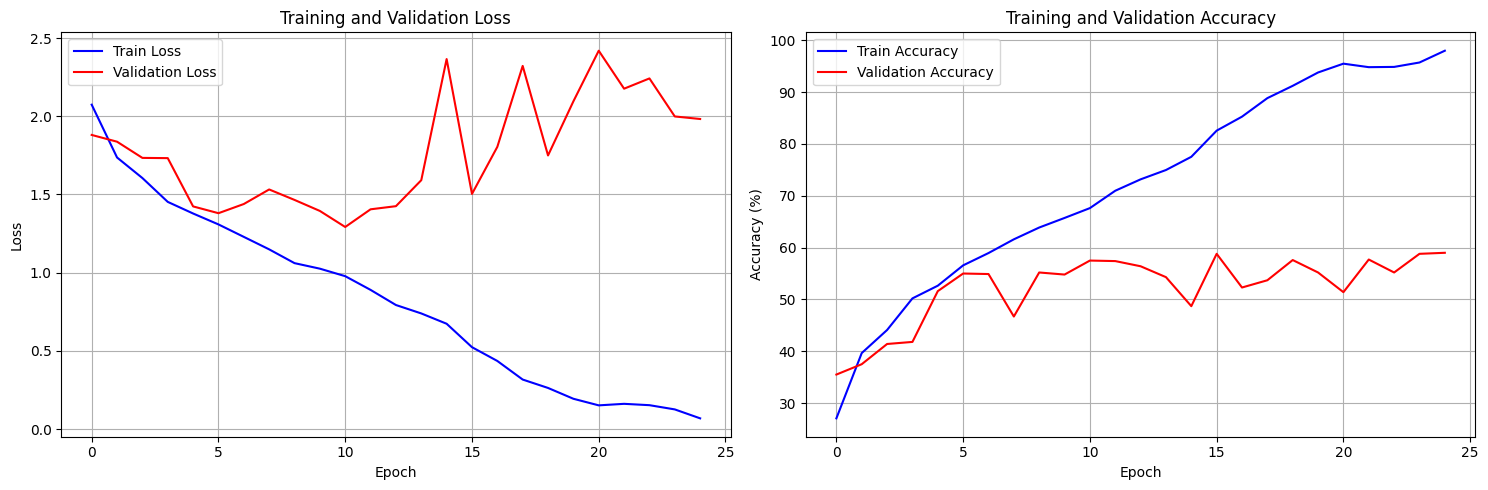

In [68]:
model = SimpleResNet18(num_classes=10)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history_simple = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=25,
    path_model= 'base_model.pth'
)

plot_training_history(history_simple)

In [149]:
df_results = pd.DataFrame({'model' : [], 'Количество параметров' : [], 'Кол-во эпох' : [], 'Val Accuracy' : [], 'Train Accuracy' : [], 'Эпоха по макс Val acc' : []})
model = SimpleResNet18(num_classes=10)
params = f'{sum(p.numel() for p in model.parameters())/1000000:.2f}M'
max_val_acc = max(history_simple['val_acc'])
idx = history_simple['val_acc'].index(max_val_acc)
train_acc = history_simple['train_acc'][idx]
epoch = len(history_simple['val_acc'])

df_results.loc[len(df_results)] = ['BaseModel', params , epoch, max_val_acc, train_acc, idx + 1]
df_results.head()

,model,Количество параметров,Кол-во эпох,Val Accuracy,Train Accuracy,Эпоха по макс Val acc
0,BaseModel,11.17M,25,59.0,98.0,25


In [70]:
print(model)

SimpleResNet18(
  (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (basic_block_1_1): BasicBlock(
    (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU(inplace=True)
    (downsample): Identity()
  )
  (basic_block_1_2): BasicBlock(
    (conv_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn_2): Batc

# Часть 3: Поэтапная оптимизация модели

## 3.1: Оптимизация количества каналов

### Вариант A: 32 → 64 → 128 → 256 каналов

In [71]:
class SimpleResNet18_31A(nn.Module):
    def __init__(self, num_classes = 10):
        super().__init__()

        self.basic_block_1_1 = BasicBlock(3, 32) # [32, 64, 64]
        self.basic_block_1_2 = BasicBlock(32, 32) # [32, 64, 64]

        self.basic_block_2_1 = BasicBlock(32, 64, stride = 2) # [64, 32, 32]
        self.basic_block_2_2 = BasicBlock(64, 64) # [64, 32, 32]

        self.basic_block_3_1 = BasicBlock(64, 128, stride = 2) # [128, 16, 16]
        self.basic_block_3_2 = BasicBlock(128, 128) # [128, 16, 16]

        self.basic_block_4_1 = BasicBlock(128, 256, stride = 2) # [256, 8, 8]
        self.basic_block_4_2 = BasicBlock(256, 256) # [256, 8, 8]

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

        self.fc = nn.Linear(in_features=256, out_features=num_classes)
    
    def forward(self, x):

        x = self.basic_block_1_1(x)
        x = self.basic_block_1_2(x)

        x = self.basic_block_2_1(x)
        x = self.basic_block_2_2(x)

        x = self.basic_block_3_1(x)
        x = self.basic_block_3_2(x)

        x = self.basic_block_4_1(x)
        x = self.basic_block_4_2(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)

        x = self.fc(x)

        return x

Обучение на 25 эпох...
 Эпоха 1/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.32it/s, loss=1.97]


 Train Loss: 1.9686, Train Acc: 30.32%
 Val Loss: 2.0307, Val Acc: 27.70%
 Сохранена лучшая модель с точностью 27.70%
 Эпоха 2/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.30it/s, loss=1.9] 


 Train Loss: 1.6715, Train Acc: 42.42%
 Val Loss: 2.2704, Val Acc: 29.40%
 Сохранена лучшая модель с точностью 29.40%
 Эпоха 3/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=1.46]


 Train Loss: 1.5573, Train Acc: 47.20%
 Val Loss: 1.6239, Val Acc: 43.40%
 Сохранена лучшая модель с точностью 43.40%
 Эпоха 4/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=1.48]


 Train Loss: 1.4489, Train Acc: 51.62%
 Val Loss: 1.6415, Val Acc: 48.50%
 Сохранена лучшая модель с точностью 48.50%
 Эпоха 5/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=1.42]


 Train Loss: 1.3529, Train Acc: 54.90%
 Val Loss: 1.5222, Val Acc: 51.00%
 Сохранена лучшая модель с точностью 51.00%
 Эпоха 6/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.33it/s, loss=1.4] 


 Train Loss: 1.2817, Train Acc: 56.55%
 Val Loss: 1.4872, Val Acc: 49.60%
 Эпоха 7/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.32it/s, loss=1.46]


 Train Loss: 1.1770, Train Acc: 60.52%
 Val Loss: 1.5222, Val Acc: 50.30%
 Эпоха 8/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.33it/s, loss=1.82]


 Train Loss: 1.1327, Train Acc: 61.67%
 Val Loss: 1.9122, Val Acc: 42.90%
 Эпоха 9/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=1.34]


 Train Loss: 1.0409, Train Acc: 65.35%
 Val Loss: 1.3702, Val Acc: 56.40%
 Сохранена лучшая модель с точностью 56.40%
 Эпоха 10/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=1.67]


 Train Loss: 0.9662, Train Acc: 67.58%
 Val Loss: 1.7092, Val Acc: 51.50%
 Эпоха 11/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=1.54]


 Train Loss: 0.8970, Train Acc: 70.05%
 Val Loss: 1.6562, Val Acc: 47.20%
 Эпоха 12/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.32it/s, loss=1.23]


 Train Loss: 0.8024, Train Acc: 72.15%
 Val Loss: 1.4164, Val Acc: 55.50%
 Эпоха 13/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.32it/s, loss=1.26]


 Train Loss: 0.7579, Train Acc: 74.05%
 Val Loss: 1.3185, Val Acc: 59.90%
 Сохранена лучшая модель с точностью 59.90%
 Эпоха 14/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.30it/s, loss=1.72]


 Train Loss: 0.6331, Train Acc: 78.70%
 Val Loss: 1.6351, Val Acc: 53.00%
 Эпоха 15/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.30it/s, loss=1.99]


 Train Loss: 0.5268, Train Acc: 82.22%
 Val Loss: 2.3455, Val Acc: 46.50%
 Эпоха 16/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=1.45]


 Train Loss: 0.4341, Train Acc: 85.50%
 Val Loss: 1.4906, Val Acc: 56.00%
 Эпоха 17/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.32it/s, loss=1.87]


 Train Loss: 0.3113, Train Acc: 90.00%
 Val Loss: 1.7201, Val Acc: 53.30%
 Эпоха 18/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.32it/s, loss=2.28]


 Train Loss: 0.2466, Train Acc: 92.42%
 Val Loss: 2.3182, Val Acc: 44.20%
 Эпоха 19/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=1.47]


 Train Loss: 0.2263, Train Acc: 92.90%
 Val Loss: 2.0510, Val Acc: 50.90%
 Эпоха 20/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=1.78]


 Train Loss: 0.1222, Train Acc: 96.47%
 Val Loss: 1.6546, Val Acc: 57.90%
 Эпоха 21/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=2.12]


 Train Loss: 0.0825, Train Acc: 98.12%
 Val Loss: 1.9424, Val Acc: 56.50%
 Эпоха 22/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.29it/s, loss=2.01]


 Train Loss: 0.0564, Train Acc: 98.88%
 Val Loss: 1.7729, Val Acc: 57.70%
 Эпоха 23/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.32it/s, loss=2.25]


 Train Loss: 0.0291, Train Acc: 99.65%
 Val Loss: 1.7991, Val Acc: 61.00%
 Сохранена лучшая модель с точностью 61.00%
 Эпоха 24/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=2.21]


 Train Loss: 0.0162, Train Acc: 99.75%
 Val Loss: 1.8941, Val Acc: 57.50%
 Эпоха 25/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.32it/s, loss=1.88]


 Train Loss: 0.0149, Train Acc: 99.85%
 Val Loss: 1.7556, Val Acc: 62.20%
 Сохранена лучшая модель с точностью 62.20%


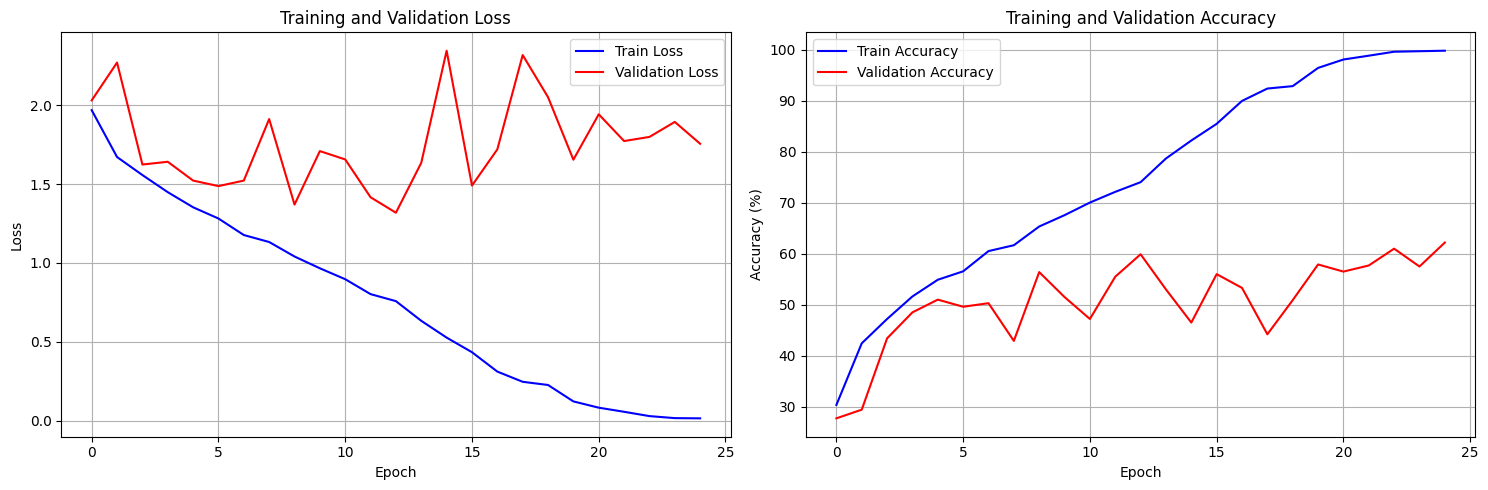

In [72]:
model = SimpleResNet18_31A(num_classes=10)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history_simple_31A = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=25,
    path_model= 'best_model_part_31A.pth'
)

plot_training_history(history_simple_31A)

In [150]:
model = SimpleResNet18_31A(num_classes=10)
params = f'{sum(p.numel() for p in model.parameters())/1000000:.2f}M'
max_val_acc = max(history_simple_31A['val_acc'])
idx = history_simple_31A['val_acc'].index(max_val_acc)
train_acc = history_simple_31A['train_acc'][idx]
epoch = len(history_simple_31A['val_acc'])

df_results.loc[len(df_results)] = ['Model_31A-[32 → 64 → 128 → 256]', params ,epoch, max_val_acc, train_acc, idx + 1]
df_results.head()

,model,Количество параметров,Кол-во эпох,Val Accuracy,Train Accuracy,Эпоха по макс Val acc
0,BaseModel,11.17M,25,59.0,98.00,25
1,Model_31A-[32 → 64 → 128 → 256],2.79M,25,62.2,99.85,25


### Вариант B: 64 → 128 → 256 каналов

In [74]:
class SimpleResNet18_31B(nn.Module):
    def __init__(self, num_classes = 10):
        super().__init__()

        self.basic_block_1_1 = BasicBlock(3, 64) # [64, 64, 64]
        self.basic_block_1_2 = BasicBlock(64, 64) # [64, 64, 64]

        self.basic_block_2_1 = BasicBlock(64, 128, stride = 2) # [128, 32, 32]
        self.basic_block_2_2 = BasicBlock(128, 128) # [128, 32, 32]

        self.basic_block_3_1 = BasicBlock(128, 256, stride = 2) # [256, 16, 16]
        self.basic_block_3_2 = BasicBlock(256, 256) # [256, 16, 16]

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

        self.fc = nn.Linear(in_features=256, out_features=num_classes)
    
    def forward(self, x):

        x = self.basic_block_1_1(x)
        x = self.basic_block_1_2(x)

        x = self.basic_block_2_1(x)
        x = self.basic_block_2_2(x)

        x = self.basic_block_3_1(x)
        x = self.basic_block_3_2(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)

        x = self.fc(x)

        return x

Обучение на 25 эпох...
 Эпоха 1/25


Validation: 100%|██████████| 16/16 [00:19<00:00,  1.19s/it, loss=2.19]


 Train Loss: 1.9894, Train Acc: 29.32%
 Val Loss: 1.9579, Val Acc: 35.70%
 Сохранена лучшая модель с точностью 35.70%
 Эпоха 2/25


Validation: 100%|██████████| 16/16 [00:19<00:00,  1.24s/it, loss=1.55]


 Train Loss: 1.6936, Train Acc: 41.30%
 Val Loss: 1.7046, Val Acc: 41.80%
 Сохранена лучшая модель с точностью 41.80%
 Эпоха 3/25


Validation: 100%|██████████| 16/16 [00:19<00:00,  1.21s/it, loss=1.47]


 Train Loss: 1.5794, Train Acc: 45.83%
 Val Loss: 1.6515, Val Acc: 42.80%
 Сохранена лучшая модель с точностью 42.80%
 Эпоха 4/25


Validation: 100%|██████████| 16/16 [00:18<00:00,  1.19s/it, loss=1.43]


 Train Loss: 1.4837, Train Acc: 49.88%
 Val Loss: 1.5842, Val Acc: 45.20%
 Сохранена лучшая модель с точностью 45.20%
 Эпоха 5/25


Validation: 100%|██████████| 16/16 [00:18<00:00,  1.18s/it, loss=1.62]


 Train Loss: 1.3808, Train Acc: 53.00%
 Val Loss: 1.6209, Val Acc: 42.10%
 Эпоха 6/25


Validation: 100%|██████████| 16/16 [00:19<00:00,  1.20s/it, loss=1.72]


 Train Loss: 1.3325, Train Acc: 54.88%
 Val Loss: 1.5992, Val Acc: 47.80%
 Сохранена лучшая модель с точностью 47.80%
 Эпоха 7/25


Validation: 100%|██████████| 16/16 [00:18<00:00,  1.18s/it, loss=1.36]


 Train Loss: 1.2688, Train Acc: 57.45%
 Val Loss: 1.4116, Val Acc: 54.10%
 Сохранена лучшая модель с точностью 54.10%
 Эпоха 8/25


Validation: 100%|██████████| 16/16 [00:18<00:00,  1.18s/it, loss=1.36]


 Train Loss: 1.2048, Train Acc: 59.92%
 Val Loss: 1.2832, Val Acc: 58.00%
 Сохранена лучшая модель с точностью 58.00%
 Эпоха 9/25


Validation: 100%|██████████| 16/16 [00:19<00:00,  1.20s/it, loss=2.1] 


 Train Loss: 1.1255, Train Acc: 62.55%
 Val Loss: 1.9705, Val Acc: 41.60%
 Эпоха 10/25


Validation: 100%|██████████| 16/16 [00:19<00:00,  1.19s/it, loss=1.32]


 Train Loss: 1.0921, Train Acc: 62.50%
 Val Loss: 1.3171, Val Acc: 59.10%
 Сохранена лучшая модель с точностью 59.10%
 Эпоха 11/25


Validation: 100%|██████████| 16/16 [00:19<00:00,  1.19s/it, loss=1.24]


 Train Loss: 1.0654, Train Acc: 64.35%
 Val Loss: 1.2582, Val Acc: 59.30%
 Сохранена лучшая модель с точностью 59.30%
 Эпоха 12/25


Validation: 100%|██████████| 16/16 [00:19<00:00,  1.19s/it, loss=1.91]


 Train Loss: 1.0045, Train Acc: 65.92%
 Val Loss: 1.6829, Val Acc: 52.20%
 Эпоха 13/25


Validation: 100%|██████████| 16/16 [00:19<00:00,  1.19s/it, loss=1.4]  


 Train Loss: 0.9515, Train Acc: 66.92%
 Val Loss: 1.3078, Val Acc: 58.20%
 Эпоха 14/25


Validation: 100%|██████████| 16/16 [00:19<00:00,  1.20s/it, loss=2.64]


 Train Loss: 0.9307, Train Acc: 69.08%
 Val Loss: 2.0641, Val Acc: 45.10%
 Эпоха 15/25


Validation: 100%|██████████| 16/16 [00:18<00:00,  1.18s/it, loss=2.54]


 Train Loss: 0.8821, Train Acc: 70.90%
 Val Loss: 1.9286, Val Acc: 52.40%
 Эпоха 16/25


Validation: 100%|██████████| 16/16 [00:19<00:00,  1.21s/it, loss=1.65]


 Train Loss: 0.8352, Train Acc: 71.58%
 Val Loss: 1.4548, Val Acc: 56.80%
 Эпоха 17/25


Validation: 100%|██████████| 16/16 [00:19<00:00,  1.20s/it, loss=1.79]


 Train Loss: 0.7753, Train Acc: 73.67%
 Val Loss: 1.4799, Val Acc: 53.50%
 Эпоха 18/25


Validation: 100%|██████████| 16/16 [00:18<00:00,  1.18s/it, loss=2.11]


 Train Loss: 0.7453, Train Acc: 75.35%
 Val Loss: 2.3430, Val Acc: 46.70%
 Эпоха 19/25


Validation: 100%|██████████| 16/16 [00:19<00:00,  1.19s/it, loss=1.88]


 Train Loss: 0.7050, Train Acc: 76.12%
 Val Loss: 1.7217, Val Acc: 53.70%
 Эпоха 20/25


Validation: 100%|██████████| 16/16 [00:19<00:00,  1.21s/it, loss=1.65]


 Train Loss: 0.6535, Train Acc: 78.03%
 Val Loss: 1.3637, Val Acc: 58.10%
 Эпоха 21/25


Validation: 100%|██████████| 16/16 [00:19<00:00,  1.19s/it, loss=1.35] 


 Train Loss: 0.5770, Train Acc: 80.22%
 Val Loss: 1.2699, Val Acc: 61.20%
 Сохранена лучшая модель с точностью 61.20%
 Эпоха 22/25


Validation: 100%|██████████| 16/16 [00:19<00:00,  1.20s/it, loss=1.83]


 Train Loss: 0.5278, Train Acc: 82.42%
 Val Loss: 1.7002, Val Acc: 55.30%
 Эпоха 23/25


Validation: 100%|██████████| 16/16 [00:18<00:00,  1.18s/it, loss=2.7] 


 Train Loss: 0.4815, Train Acc: 83.72%
 Val Loss: 2.2072, Val Acc: 51.40%
 Эпоха 24/25


Validation: 100%|██████████| 16/16 [00:19<00:00,  1.20s/it, loss=1.95] 


 Train Loss: 0.4153, Train Acc: 86.08%
 Val Loss: 1.3927, Val Acc: 61.40%
 Сохранена лучшая модель с точностью 61.40%
 Эпоха 25/25


Validation: 100%|██████████| 16/16 [00:19<00:00,  1.21s/it, loss=2.74]


 Train Loss: 0.3457, Train Acc: 89.08%
 Val Loss: 2.2082, Val Acc: 50.90%


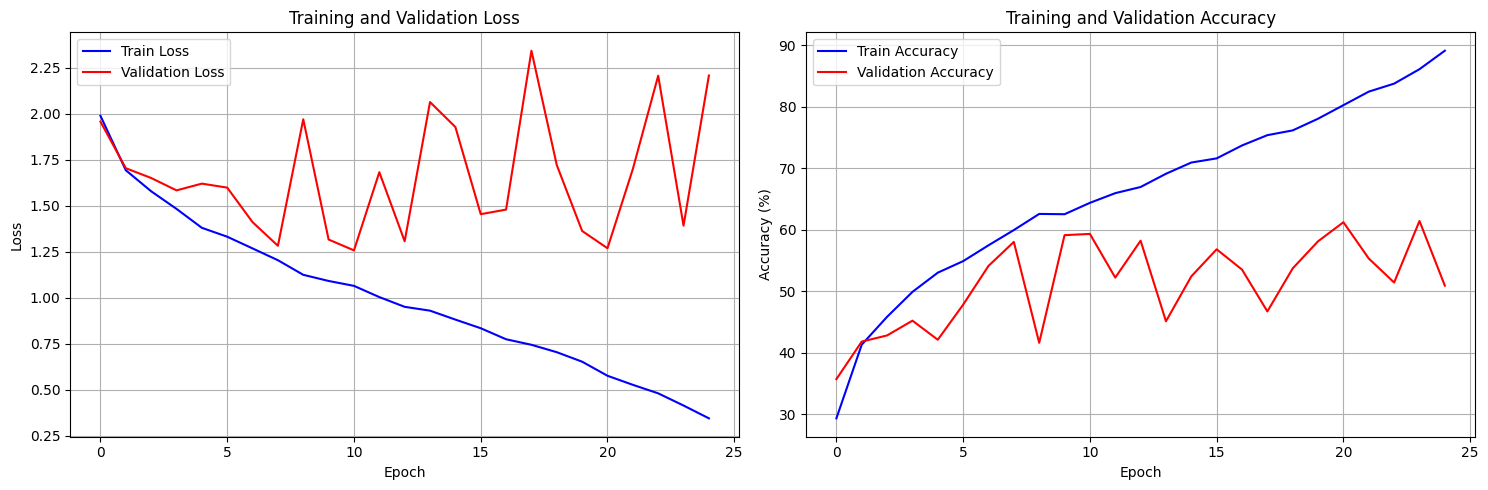

In [75]:
model = SimpleResNet18_31B(num_classes=10)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history_simple_31B = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=25,
    path_model= 'best_model_part_31B.pth'
)

plot_training_history(history_simple_31B)

In [151]:
model = SimpleResNet18_31B(num_classes=10)
params = f'{sum(p.numel() for p in model.parameters())/1000000:.2f}M'
max_val_acc = max(history_simple_31B['val_acc'])
idx = history_simple_31B['val_acc'].index(max_val_acc)
train_acc = history_simple_31B['train_acc'][idx]
epoch = len(history_simple_31B['val_acc'])

df_results.loc[len(df_results)] = ['Model_31B-[64 → 128 → 256]', params ,epoch, max_val_acc, train_acc, idx + 1]
df_results.head()

,model,Количество параметров,Кол-во эпох,Val Accuracy,Train Accuracy,Эпоха по макс Val acc
0,BaseModel,11.17M,25,59.0,98.000,25
1,Model_31A-[32 → 64 → 128 → 256],2.79M,25,62.2,99.850,25
2,Model_31B-[64 → 128 → 256],2.74M,25,61.4,86.075,24


**Вывод** : В результате изучения влияния количества каналов на производительность, конфигурация А является лучше.

## 3.2: Эксперименты с количеством residual блоков

### Вариант A: [1, 1, 1, 1] - по 1 блоку в каждом слое (мелкая сеть)

In [77]:
class SimpleResNet18_32A(nn.Module):
    def __init__(self, num_classes = 10):
        super().__init__()

        self.basic_block_1_1 = BasicBlock(3, 32) # [64, 64, 64]
        self.basic_block_2_1 = BasicBlock(32, 64, stride = 2) # [64, 32, 32]
        self.basic_block_3_1 = BasicBlock(64, 128, stride = 2) # [128, 16, 16]
        self.basic_block_4_1 = BasicBlock(128, 256, stride = 2) # [256, 8, 8]

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

        self.fc = nn.Linear(in_features=256, out_features=num_classes)
    
    def forward(self, x):

        x = self.basic_block_1_1(x)
        x = self.basic_block_2_1(x)
        x = self.basic_block_3_1(x)
        x = self.basic_block_4_1(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)

        x = self.fc(x)

        return x


model = SimpleResNet18_32A(num_classes=10)
test_tensor = torch.randn(1, 3, 64, 64)
print(model(test_tensor).shape)

torch.Size([1, 10])


Обучение на 25 эпох...
 Эпоха 1/25


Validation: 100%|██████████| 16/16 [00:08<00:00,  1.90it/s, loss=1.91]


 Train Loss: 1.8784, Train Acc: 35.27%
 Val Loss: 1.8514, Val Acc: 33.50%
 Сохранена лучшая модель с точностью 33.50%
 Эпоха 2/25


Validation: 100%|██████████| 16/16 [00:07<00:00,  2.07it/s, loss=1.77]


 Train Loss: 1.5780, Train Acc: 46.00%
 Val Loss: 1.7365, Val Acc: 38.10%
 Сохранена лучшая модель с точностью 38.10%
 Эпоха 3/25


Validation: 100%|██████████| 16/16 [00:07<00:00,  2.05it/s, loss=1.54]


 Train Loss: 1.4458, Train Acc: 51.33%
 Val Loss: 1.5337, Val Acc: 48.80%
 Сохранена лучшая модель с точностью 48.80%
 Эпоха 4/25


Validation: 100%|██████████| 16/16 [00:07<00:00,  2.06it/s, loss=1.74]


 Train Loss: 1.3302, Train Acc: 54.98%
 Val Loss: 1.5420, Val Acc: 47.40%
 Эпоха 5/25


Validation: 100%|██████████| 16/16 [00:07<00:00,  2.04it/s, loss=1.49]


 Train Loss: 1.2303, Train Acc: 59.23%
 Val Loss: 1.4775, Val Acc: 50.50%
 Сохранена лучшая модель с точностью 50.50%
 Эпоха 6/25


Validation: 100%|██████████| 16/16 [00:07<00:00,  2.04it/s, loss=1.6] 


 Train Loss: 1.1546, Train Acc: 60.88%
 Val Loss: 1.8278, Val Acc: 45.80%
 Эпоха 7/25


Validation: 100%|██████████| 16/16 [00:07<00:00,  2.08it/s, loss=1.4] 


 Train Loss: 1.0639, Train Acc: 64.70%
 Val Loss: 1.4846, Val Acc: 51.50%
 Сохранена лучшая модель с точностью 51.50%
 Эпоха 8/25


Validation: 100%|██████████| 16/16 [00:07<00:00,  2.09it/s, loss=1.67]


 Train Loss: 0.9668, Train Acc: 67.97%
 Val Loss: 1.6430, Val Acc: 50.20%
 Эпоха 9/25


Validation: 100%|██████████| 16/16 [00:07<00:00,  2.10it/s, loss=1.65]


 Train Loss: 0.8649, Train Acc: 70.83%
 Val Loss: 1.8670, Val Acc: 46.40%
 Эпоха 10/25


Validation: 100%|██████████| 16/16 [00:07<00:00,  2.10it/s, loss=1.48]


 Train Loss: 0.7782, Train Acc: 74.58%
 Val Loss: 1.3773, Val Acc: 53.10%
 Сохранена лучшая модель с точностью 53.10%
 Эпоха 11/25


Validation: 100%|██████████| 16/16 [00:07<00:00,  2.09it/s, loss=1.79]


 Train Loss: 0.6482, Train Acc: 79.33%
 Val Loss: 1.6887, Val Acc: 50.90%
 Эпоха 12/25


Validation: 100%|██████████| 16/16 [00:07<00:00,  2.09it/s, loss=1.66]


 Train Loss: 0.5254, Train Acc: 83.60%
 Val Loss: 1.5823, Val Acc: 54.60%
 Сохранена лучшая модель с точностью 54.60%
 Эпоха 13/25


Validation: 100%|██████████| 16/16 [00:07<00:00,  2.09it/s, loss=1.4] 


 Train Loss: 0.3867, Train Acc: 88.55%
 Val Loss: 2.0626, Val Acc: 46.70%
 Эпоха 14/25


Validation: 100%|██████████| 16/16 [00:07<00:00,  2.09it/s, loss=1.77]


 Train Loss: 0.2644, Train Acc: 92.45%
 Val Loss: 1.6570, Val Acc: 54.40%
 Эпоха 15/25


Validation: 100%|██████████| 16/16 [00:07<00:00,  2.11it/s, loss=1.52]


 Train Loss: 0.1724, Train Acc: 96.22%
 Val Loss: 1.9581, Val Acc: 52.70%
 Эпоха 16/25


Validation: 100%|██████████| 16/16 [00:07<00:00,  2.10it/s, loss=1.93]


 Train Loss: 0.1134, Train Acc: 97.67%
 Val Loss: 1.6545, Val Acc: 54.80%
 Сохранена лучшая модель с точностью 54.80%
 Эпоха 17/25


Validation: 100%|██████████| 16/16 [00:07<00:00,  2.07it/s, loss=1.58]


 Train Loss: 0.0648, Train Acc: 98.90%
 Val Loss: 1.6228, Val Acc: 58.40%
 Сохранена лучшая модель с точностью 58.40%
 Эпоха 18/25


Validation: 100%|██████████| 16/16 [00:07<00:00,  2.02it/s, loss=2.17]


 Train Loss: 0.0488, Train Acc: 99.30%
 Val Loss: 1.9072, Val Acc: 56.80%
 Эпоха 19/25


Validation: 100%|██████████| 16/16 [00:07<00:00,  2.07it/s, loss=1.97]


 Train Loss: 0.0473, Train Acc: 99.15%
 Val Loss: 1.8501, Val Acc: 55.60%
 Эпоха 20/25


Validation: 100%|██████████| 16/16 [00:07<00:00,  2.06it/s, loss=1.98]


 Train Loss: 0.0333, Train Acc: 99.53%
 Val Loss: 1.8331, Val Acc: 56.00%
 Эпоха 21/25


Validation: 100%|██████████| 16/16 [00:07<00:00,  2.07it/s, loss=1.7] 


 Train Loss: 0.0228, Train Acc: 99.75%
 Val Loss: 1.7602, Val Acc: 56.40%
 Эпоха 22/25


Validation: 100%|██████████| 16/16 [00:07<00:00,  2.07it/s, loss=1.66]


 Train Loss: 0.0085, Train Acc: 99.97%
 Val Loss: 1.6562, Val Acc: 59.50%
 Сохранена лучшая модель с точностью 59.50%
 Эпоха 23/25


Validation: 100%|██████████| 16/16 [00:07<00:00,  2.03it/s, loss=1.71]


 Train Loss: 0.0038, Train Acc: 100.00%
 Val Loss: 1.5999, Val Acc: 60.20%
 Сохранена лучшая модель с точностью 60.20%
 Эпоха 24/25


Validation: 100%|██████████| 16/16 [00:07<00:00,  2.03it/s, loss=1.67]


 Train Loss: 0.0028, Train Acc: 100.00%
 Val Loss: 1.6447, Val Acc: 60.00%
 Эпоха 25/25


Validation: 100%|██████████| 16/16 [00:07<00:00,  2.02it/s, loss=1.68]

 Train Loss: 0.0025, Train Acc: 100.00%
 Val Loss: 1.6551, Val Acc: 59.40%


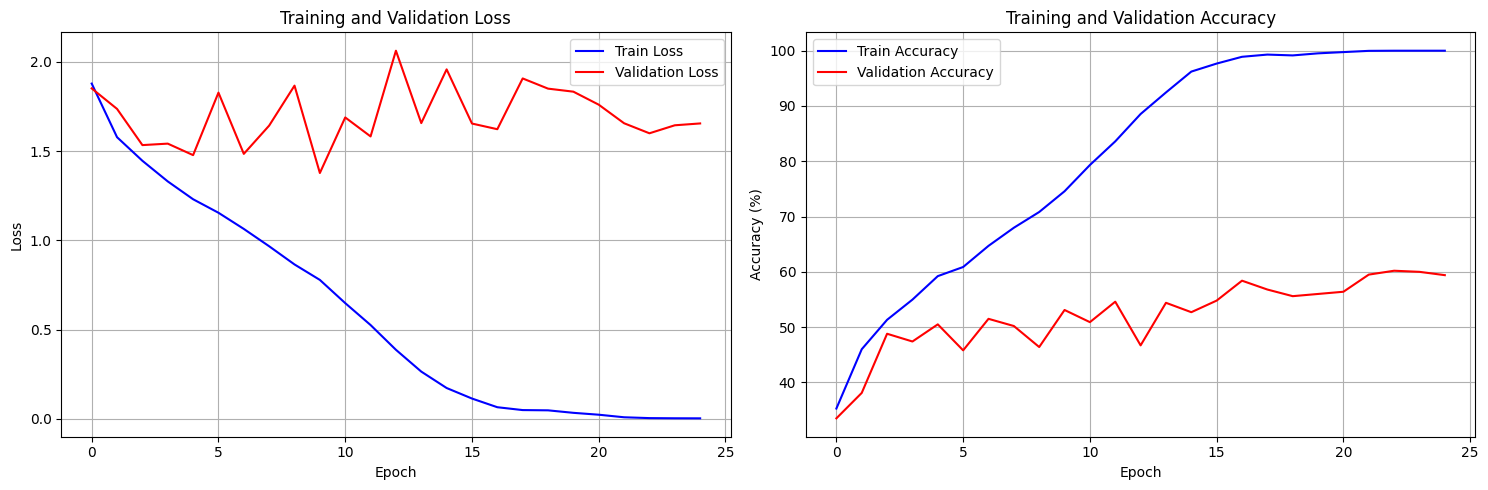

In [78]:
model = SimpleResNet18_32A(num_classes=10)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history_simple_32A = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=25,
    path_model= 'best_model_part_32A.pth'
)

plot_training_history(history_simple_32A)

In [152]:
model = SimpleResNet18_32A(num_classes=10)
params = f'{sum(p.numel() for p in model.parameters())/1000000:.2f}M'
max_val_acc = max(history_simple_32A['val_acc'])
idx = history_simple_32A['val_acc'].index(max_val_acc)
train_acc = history_simple_32A['train_acc'][idx]
epoch = len(history_simple_32A['val_acc'])

df_results.loc[len(df_results)] = ['Model_32A-[1,1,1,1]', params ,epoch, max_val_acc, train_acc, idx + 1]
df_results.head()

,model,Количество параметров,Кол-во эпох,Val Accuracy,Train Accuracy,Эпоха по макс Val acc
0,BaseModel,11.17M,25,59.0,98.000,25
1,Model_31A-[32 → 64 → 128 → 256],2.79M,25,62.2,99.850,25
2,Model_31B-[64 → 128 → 256],2.74M,25,61.4,86.075,24
3,"Model_32A-[1,1,1,1]",1.22M,25,60.2,100.000,23


### Вариант C: [3, 3, 3, 3] - по 3 блока в каждом слое (глубокая сеть)

In [80]:
class SimpleResNet18_32C(nn.Module):
    def __init__(self, num_classes = 10):
        super().__init__()

        self.basic_block_1_1 = BasicBlock(3, 32) # [32, 64, 64]
        self.basic_block_1_2 = BasicBlock(32, 32) # [32, 64, 64]
        self.basic_block_1_3 = BasicBlock(32, 32) # [32, 64, 64]

        self.basic_block_2_1 = BasicBlock(32, 64, stride = 2) # [64, 32, 32]
        self.basic_block_2_2 = BasicBlock(64, 64) # [64, 32, 32]
        self.basic_block_2_3 = BasicBlock(64, 64) # [64, 32, 32]

        self.basic_block_3_1 = BasicBlock(64, 128, stride = 2) # [128, 16, 16]
        self.basic_block_3_2 = BasicBlock(128, 128) # [128, 16, 16]
        self.basic_block_3_3 = BasicBlock(128, 128) # [128, 16, 16]

        self.basic_block_4_1 = BasicBlock(128, 256, stride = 2) # [256, 8, 8]
        self.basic_block_4_2 = BasicBlock(256, 256) # [256, 8, 8]
        self.basic_block_4_3 = BasicBlock(256, 256) # [256, 8, 8]

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

        self.fc = nn.Linear(in_features=256, out_features=num_classes)
    
    def forward(self, x):

        x = self.basic_block_1_1(x)
        x = self.basic_block_1_2(x)
        x = self.basic_block_1_3(x)

        x = self.basic_block_2_1(x)
        x = self.basic_block_2_2(x)
        x = self.basic_block_2_3(x)

        x = self.basic_block_3_1(x)
        x = self.basic_block_3_2(x)
        x = self.basic_block_3_3(x)

        x = self.basic_block_4_1(x)
        x = self.basic_block_4_2(x)
        x = self.basic_block_4_3(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)

        x = self.fc(x)

        return x


model = SimpleResNet18_32C(num_classes=10)
test_tensor = torch.randn(1, 3, 64, 64)
print(model(test_tensor).shape)

torch.Size([1, 10])


Обучение на 25 эпох...
 Эпоха 1/25


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it, loss=2.72]


 Train Loss: 2.0914, Train Acc: 26.23%
 Val Loss: 2.8348, Val Acc: 21.60%
 Сохранена лучшая модель с точностью 21.60%
 Эпоха 2/25


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it, loss=2.28]


 Train Loss: 1.8084, Train Acc: 36.70%
 Val Loss: 2.0170, Val Acc: 36.50%
 Сохранена лучшая модель с точностью 36.50%
 Эпоха 3/25


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it, loss=1.85]


 Train Loss: 1.6844, Train Acc: 41.75%
 Val Loss: 1.7852, Val Acc: 37.80%
 Сохранена лучшая модель с точностью 37.80%
 Эпоха 4/25


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it, loss=1.64]


 Train Loss: 1.5810, Train Acc: 45.08%
 Val Loss: 1.6735, Val Acc: 41.40%
 Сохранена лучшая модель с точностью 41.40%
 Эпоха 5/25


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it, loss=1.87]


 Train Loss: 1.4808, Train Acc: 48.67%
 Val Loss: 1.7264, Val Acc: 42.70%
 Сохранена лучшая модель с точностью 42.70%
 Эпоха 6/25


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.03s/it, loss=1.65]


 Train Loss: 1.4030, Train Acc: 51.92%
 Val Loss: 1.6551, Val Acc: 48.40%
 Сохранена лучшая модель с точностью 48.40%
 Эпоха 7/25


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it, loss=1.35]


 Train Loss: 1.3301, Train Acc: 54.35%
 Val Loss: 1.4972, Val Acc: 50.20%
 Сохранена лучшая модель с точностью 50.20%
 Эпоха 8/25


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it, loss=1.34]


 Train Loss: 1.2436, Train Acc: 58.00%
 Val Loss: 1.4178, Val Acc: 52.40%
 Сохранена лучшая модель с точностью 52.40%
 Эпоха 9/25


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it, loss=1.55]


 Train Loss: 1.2123, Train Acc: 59.17%
 Val Loss: 1.3983, Val Acc: 53.00%
 Сохранена лучшая модель с точностью 53.00%
 Эпоха 10/25


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it, loss=1.3] 


 Train Loss: 1.1276, Train Acc: 61.67%
 Val Loss: 1.3979, Val Acc: 54.50%
 Сохранена лучшая модель с точностью 54.50%
 Эпоха 11/25


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it, loss=1.5] 


 Train Loss: 1.0760, Train Acc: 64.20%
 Val Loss: 1.4932, Val Acc: 50.80%
 Эпоха 12/25


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it, loss=1.56] 


 Train Loss: 1.0182, Train Acc: 65.78%
 Val Loss: 1.3696, Val Acc: 56.80%
 Сохранена лучшая модель с точностью 56.80%
 Эпоха 13/25


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it, loss=1.49]


 Train Loss: 0.9537, Train Acc: 67.97%
 Val Loss: 1.5268, Val Acc: 51.80%
 Эпоха 14/25


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it, loss=1.74]


 Train Loss: 0.8940, Train Acc: 69.42%
 Val Loss: 1.5763, Val Acc: 56.10%
 Эпоха 15/25


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it, loss=1.25]


 Train Loss: 0.8168, Train Acc: 72.15%
 Val Loss: 1.3383, Val Acc: 56.70%
 Эпоха 16/25


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it, loss=1.54] 


 Train Loss: 0.7358, Train Acc: 75.40%
 Val Loss: 1.3996, Val Acc: 55.20%
 Эпоха 17/25


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it, loss=1.11]


 Train Loss: 0.6919, Train Acc: 76.53%
 Val Loss: 1.3269, Val Acc: 60.90%
 Сохранена лучшая модель с точностью 60.90%
 Эпоха 18/25


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it, loss=1.82]


 Train Loss: 0.5999, Train Acc: 78.88%
 Val Loss: 1.7374, Val Acc: 53.10%
 Эпоха 19/25


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it, loss=1.5] 


 Train Loss: 0.5422, Train Acc: 81.60%
 Val Loss: 1.4830, Val Acc: 58.80%
 Эпоха 20/25


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it, loss=1.38]


 Train Loss: 0.4649, Train Acc: 83.88%
 Val Loss: 1.6162, Val Acc: 58.40%
 Эпоха 21/25


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it, loss=1.68]


 Train Loss: 0.3221, Train Acc: 88.85%
 Val Loss: 1.7564, Val Acc: 54.80%
 Эпоха 22/25


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it, loss=2.14]


 Train Loss: 0.3116, Train Acc: 89.50%
 Val Loss: 1.8968, Val Acc: 57.30%
 Эпоха 23/25


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it, loss=2.14]


 Train Loss: 0.2260, Train Acc: 92.42%
 Val Loss: 1.8422, Val Acc: 56.90%
 Эпоха 24/25


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.04s/it, loss=1.68]


 Train Loss: 0.1784, Train Acc: 93.95%
 Val Loss: 1.7986, Val Acc: 55.20%
 Эпоха 25/25


Validation: 100%|██████████| 16/16 [00:16<00:00,  1.04s/it, loss=1.91]

 Train Loss: 0.1328, Train Acc: 95.92%
 Val Loss: 1.7553, Val Acc: 58.30%


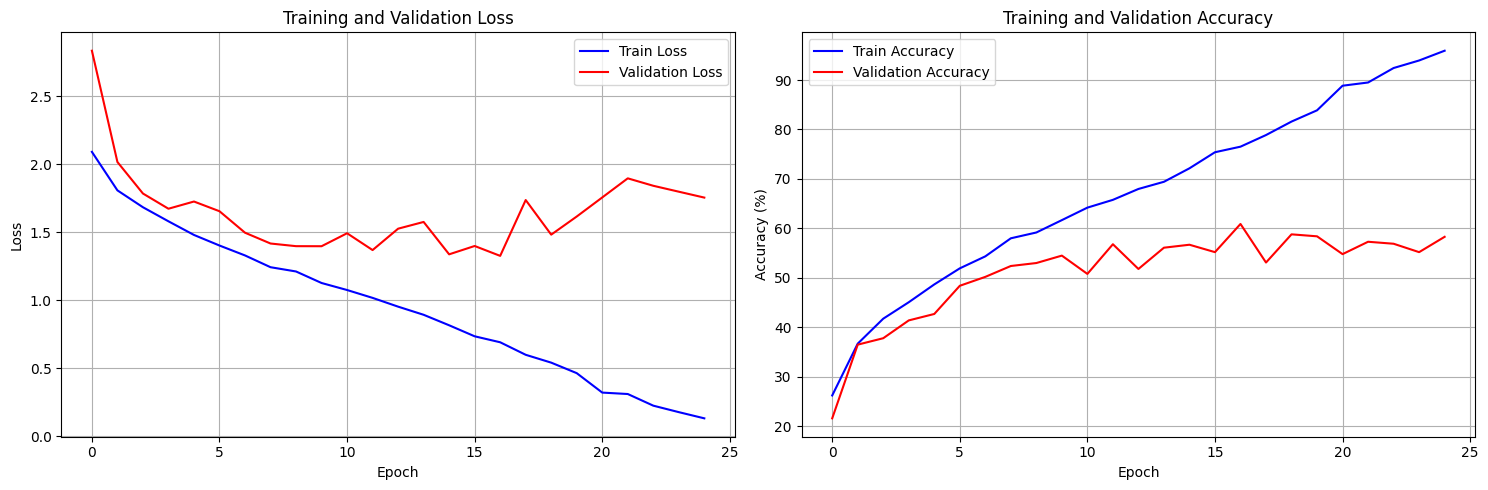

In [81]:
model = SimpleResNet18_32C(num_classes=10)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history_simple_32C = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=25,
    path_model= 'best_model_part_32C.pth'
)

plot_training_history(history_simple_32C)

In [153]:
model = SimpleResNet18_31A(num_classes=10)
params = f'{sum(p.numel() for p in model.parameters())/1000000:.2f}M'
max_val_acc = max(history_simple_31A['val_acc'])
idx = history_simple_31A['val_acc'].index(max_val_acc)
train_acc = history_simple_31A['train_acc'][idx]
epoch = len(history_simple_31A['val_acc'])

df_results.loc[len(df_results)] = ['Model_32B-[2,2,2,2]', params ,epoch, max_val_acc, train_acc, idx + 1]
df_results.head()

,model,Количество параметров,Кол-во эпох,Val Accuracy,Train Accuracy,Эпоха по макс Val acc
0,BaseModel,11.17M,25,59.0,98.000,25
1,Model_31A-[32 → 64 → 128 → 256],2.79M,25,62.2,99.850,25
2,Model_31B-[64 → 128 → 256],2.74M,25,61.4,86.075,24
3,"Model_32A-[1,1,1,1]",1.22M,25,60.2,100.000,23
4,"Model_32B-[2,2,2,2]",2.79M,25,62.2,99.850,25


In [154]:
model = SimpleResNet18_32C(num_classes=10)
params = f'{sum(p.numel() for p in model.parameters())/1000000:.2f}M'
max_val_acc = max(history_simple_32C['val_acc'])
idx = history_simple_32C['val_acc'].index(max_val_acc)
train_acc = history_simple_32C['train_acc'][idx]
epoch = len(history_simple_32C['val_acc'])

df_results.loc[len(df_results)] = ['Model_32C-[3,3,3,3]', params ,epoch, max_val_acc, train_acc, idx + 1]
df_results.head(10)

,model,Количество параметров,Кол-во эпох,Val Accuracy,Train Accuracy,Эпоха по макс Val acc
0,BaseModel,11.17M,25,59.0,98.000,25
1,Model_31A-[32 → 64 → 128 → 256],2.79M,25,62.2,99.850,25
2,Model_31B-[64 → 128 → 256],2.74M,25,61.4,86.075,24
3,"Model_32A-[1,1,1,1]",1.22M,25,60.2,100.000,23
4,"Model_32B-[2,2,2,2]",2.79M,25,62.2,99.850,25
5,"Model_32C-[3,3,3,3]",4.36M,25,60.9,76.525,17


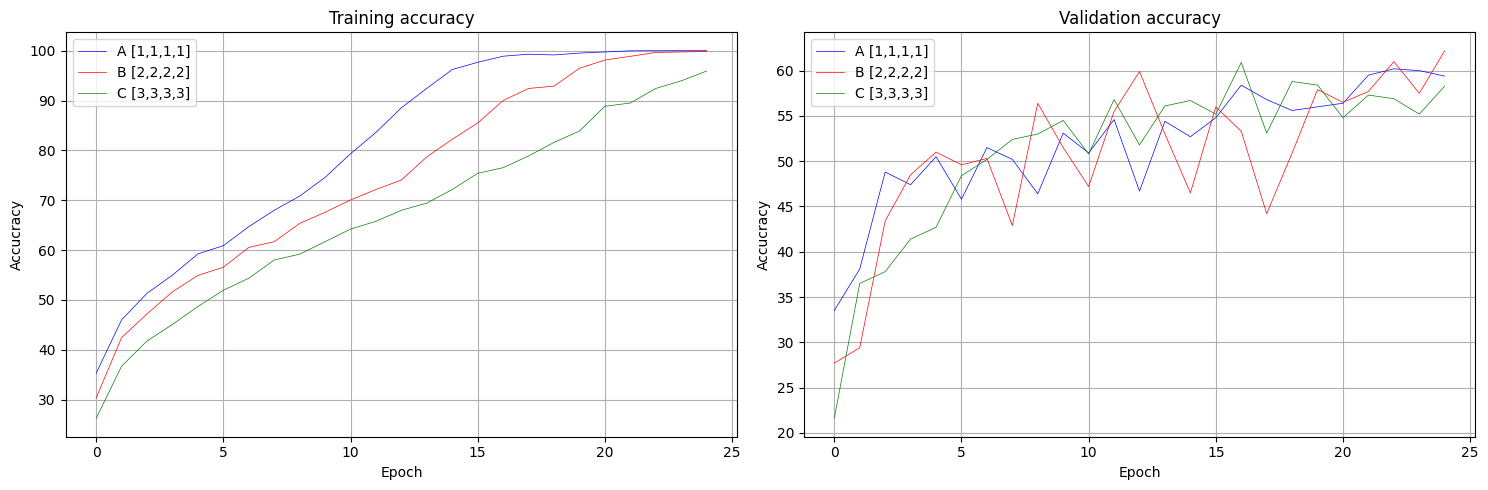

In [115]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


ax1.plot(history_simple_32A['train_acc'], label='A [1,1,1,1]', color='blue', linewidth=0.5)
ax1.plot(history_simple_31A['train_acc'], label='B [2,2,2,2]', color='red', linewidth=0.5)
ax1.plot(history_simple_32C['train_acc'], label='C [3,3,3,3]', color='green', linewidth=0.5)
ax1.set_title('Training accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accucracy')
ax1.legend()
ax1.grid(True)

ax2.plot(history_simple_32A['val_acc'], label='A [1,1,1,1]', color='blue', linewidth=0.5)
ax2.plot(history_simple_31A['val_acc'], label='B [2,2,2,2]', color='red', linewidth=0.5)
ax2.plot(history_simple_32C['val_acc'], label='C [3,3,3,3]', color='green', linewidth=0.5)
ax2.set_title('Validation accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accucracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

**Вывод**: В результате эксперимента с количеством residual блоков, лучшим является вариант B: [2, 2, 2, 2] - по 2 блока в каждом слое (стандартная ResNet18)

## 3.3: Эксперименты с функциями активации

### Вариант А: ReLU

In [155]:
model = SimpleResNet18_31A(num_classes=10)
params = f'{sum(p.numel() for p in model.parameters())/1000000:.2f}M'
max_val_acc = max(history_simple_31A['val_acc'])
idx = history_simple_31A['val_acc'].index(max_val_acc)
train_acc = history_simple_31A['train_acc'][idx]
epoch = len(history_simple_31A['val_acc'])

df_results.loc[len(df_results)] = ['Model_33A-ReLU', params ,epoch, max_val_acc, train_acc, idx + 1]
df_results.head(10)

,model,Количество параметров,Кол-во эпох,Val Accuracy,Train Accuracy,Эпоха по макс Val acc
0,BaseModel,11.17M,25,59.0,98.000,25
1,Model_31A-[32 → 64 → 128 → 256],2.79M,25,62.2,99.850,25
2,Model_31B-[64 → 128 → 256],2.74M,25,61.4,86.075,24
3,"Model_32A-[1,1,1,1]",1.22M,25,60.2,100.000,23
4,"Model_32B-[2,2,2,2]",2.79M,25,62.2,99.850,25
5,"Model_32C-[3,3,3,3]",4.36M,25,60.9,76.525,17
6,Model_33A-ReLU,2.79M,25,62.2,99.850,25


### Вариант B: LeakyReLU

In [116]:
class SimpleResNet18_33B(nn.Module):
    def __init__(self, num_classes = 10):
        super().__init__()

        self.basic_block_1_1 = BasicBlock(3, 32, activation='leakyrelu') # [32, 64, 64]
        self.basic_block_1_2 = BasicBlock(32, 32, activation='leakyrelu') # [32, 64, 64]

        self.basic_block_2_1 = BasicBlock(32, 64, stride = 2, activation='leakyrelu') # [64, 32, 32]
        self.basic_block_2_2 = BasicBlock(64, 64, activation='leakyrelu') # [64, 32, 32]

        self.basic_block_3_1 = BasicBlock(64, 128, stride = 2, activation='leakyrelu') # [128, 16, 16]
        self.basic_block_3_2 = BasicBlock(128, 128, activation='leakyrelu') # [128, 16, 16]

        self.basic_block_4_1 = BasicBlock(128, 256, stride = 2, activation='leakyrelu') # [256, 8, 8]
        self.basic_block_4_2 = BasicBlock(256, 256, activation='leakyrelu') # [256, 8, 8]

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

        self.fc = nn.Linear(in_features=256, out_features=num_classes)
    
    def forward(self, x):

        x = self.basic_block_1_1(x)
        x = self.basic_block_1_2(x)

        x = self.basic_block_2_1(x)
        x = self.basic_block_2_2(x)

        x = self.basic_block_3_1(x)
        x = self.basic_block_3_2(x)

        x = self.basic_block_4_1(x)
        x = self.basic_block_4_2(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)

        x = self.fc(x)

        return x

Обучение на 25 эпох...
 Эпоха 1/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.23it/s, loss=2.11]


 Train Loss: 1.9380, Train Acc: 32.75%
 Val Loss: 2.2043, Val Acc: 31.70%
 Сохранена лучшая модель с точностью 31.70%
 Эпоха 2/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.30it/s, loss=1.68]


 Train Loss: 1.6460, Train Acc: 43.58%
 Val Loss: 1.8538, Val Acc: 37.70%
 Сохранена лучшая модель с точностью 37.70%
 Эпоха 3/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.30it/s, loss=1.71]


 Train Loss: 1.5040, Train Acc: 49.00%
 Val Loss: 1.7789, Val Acc: 39.10%
 Сохранена лучшая модель с точностью 39.10%
 Эпоха 4/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=1.46]


 Train Loss: 1.3926, Train Acc: 53.52%
 Val Loss: 1.4730, Val Acc: 51.20%
 Сохранена лучшая модель с точностью 51.20%
 Эпоха 5/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=1.62]


 Train Loss: 1.3274, Train Acc: 55.75%
 Val Loss: 1.6724, Val Acc: 45.10%
 Эпоха 6/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.29it/s, loss=1.58]


 Train Loss: 1.2483, Train Acc: 58.77%
 Val Loss: 1.5606, Val Acc: 50.20%
 Эпоха 7/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=1.54]


 Train Loss: 1.1701, Train Acc: 60.95%
 Val Loss: 1.3987, Val Acc: 54.40%
 Сохранена лучшая модель с точностью 54.40%
 Эпоха 8/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.29it/s, loss=1.7] 


 Train Loss: 1.1166, Train Acc: 62.12%
 Val Loss: 1.7063, Val Acc: 45.80%
 Эпоха 9/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.28it/s, loss=1.36]


 Train Loss: 1.0303, Train Acc: 64.85%
 Val Loss: 1.3198, Val Acc: 56.70%
 Сохранена лучшая модель с точностью 56.70%
 Эпоха 10/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.29it/s, loss=1.35]


 Train Loss: 0.9618, Train Acc: 67.40%
 Val Loss: 1.3473, Val Acc: 54.80%
 Эпоха 11/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.29it/s, loss=1.56]


 Train Loss: 0.8729, Train Acc: 71.28%
 Val Loss: 1.4581, Val Acc: 55.00%
 Эпоха 12/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.29it/s, loss=1.58]


 Train Loss: 0.8165, Train Acc: 71.35%
 Val Loss: 1.4445, Val Acc: 58.00%
 Сохранена лучшая модель с точностью 58.00%
 Эпоха 13/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.29it/s, loss=1.65]


 Train Loss: 0.6733, Train Acc: 77.50%
 Val Loss: 1.4508, Val Acc: 52.00%
 Эпоха 14/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.29it/s, loss=2.39]


 Train Loss: 0.6058, Train Acc: 79.15%
 Val Loss: 1.9960, Val Acc: 47.80%
 Эпоха 15/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.29it/s, loss=1.89]


 Train Loss: 0.5600, Train Acc: 81.03%
 Val Loss: 1.7589, Val Acc: 49.60%
 Эпоха 16/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.29it/s, loss=1.95]


 Train Loss: 0.3968, Train Acc: 87.05%
 Val Loss: 1.5773, Val Acc: 57.40%
 Эпоха 17/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.29it/s, loss=2.41]


 Train Loss: 0.2748, Train Acc: 91.47%
 Val Loss: 1.9189, Val Acc: 52.90%
 Эпоха 18/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.29it/s, loss=1.94]


 Train Loss: 0.1934, Train Acc: 94.30%
 Val Loss: 2.0450, Val Acc: 51.40%
 Эпоха 19/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.29it/s, loss=2.34]


 Train Loss: 0.2006, Train Acc: 93.65%
 Val Loss: 2.0890, Val Acc: 48.40%
 Эпоха 20/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.29it/s, loss=2.46]


 Train Loss: 0.1674, Train Acc: 95.00%
 Val Loss: 2.1489, Val Acc: 51.30%
 Эпоха 21/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.28it/s, loss=1.74]


 Train Loss: 0.1425, Train Acc: 95.58%
 Val Loss: 2.3606, Val Acc: 48.30%
 Эпоха 22/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.29it/s, loss=2.19]


 Train Loss: 0.0759, Train Acc: 98.22%
 Val Loss: 1.9291, Val Acc: 58.80%
 Сохранена лучшая модель с точностью 58.80%
 Эпоха 23/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.29it/s, loss=2.43]


 Train Loss: 0.0612, Train Acc: 98.38%
 Val Loss: 2.1689, Val Acc: 56.10%
 Эпоха 24/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.29it/s, loss=2]   


 Train Loss: 0.0260, Train Acc: 99.65%
 Val Loss: 1.6762, Val Acc: 60.20%
 Сохранена лучшая модель с точностью 60.20%
 Эпоха 25/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.30it/s, loss=1.87]


 Train Loss: 0.0117, Train Acc: 99.83%
 Val Loss: 1.7008, Val Acc: 60.00%


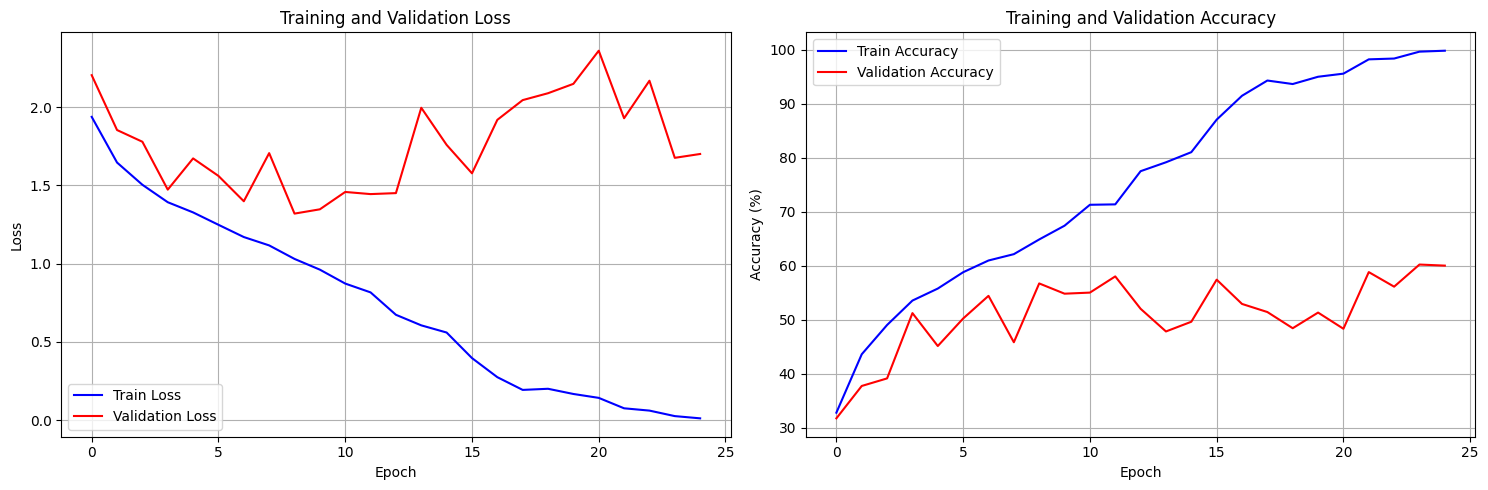

In [117]:
model = SimpleResNet18_33B(num_classes=10)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history_simple_33B = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=25,
    path_model= 'best_model_part_33B.pth'
)

plot_training_history(history_simple_33B)

In [156]:
model = SimpleResNet18_33B(num_classes=10)
params = f'{sum(p.numel() for p in model.parameters())/1000000:.2f}M'
max_val_acc = max(history_simple_33B['val_acc'])
idx = history_simple_33B['val_acc'].index(max_val_acc)
train_acc = history_simple_33B['train_acc'][idx]
epoch = len(history_simple_33B['val_acc'])

df_results.loc[len(df_results)] = ['Model_33B-LeakyReLU', params ,epoch, max_val_acc, train_acc, idx + 1]
df_results.head(10)

,model,Количество параметров,Кол-во эпох,Val Accuracy,Train Accuracy,Эпоха по макс Val acc
0,BaseModel,11.17M,25,59.0,98.000,25
1,Model_31A-[32 → 64 → 128 → 256],2.79M,25,62.2,99.850,25
2,Model_31B-[64 → 128 → 256],2.74M,25,61.4,86.075,24
3,"Model_32A-[1,1,1,1]",1.22M,25,60.2,100.000,23
4,"Model_32B-[2,2,2,2]",2.79M,25,62.2,99.850,25
5,"Model_32C-[3,3,3,3]",4.36M,25,60.9,76.525,17
6,Model_33A-ReLU,2.79M,25,62.2,99.850,25
7,Model_33B-LeakyReLU,2.79M,25,60.2,99.650,24


### Вариант C: ELU

In [119]:
class SimpleResNet18_33C(nn.Module):
    def __init__(self, num_classes = 10):
        super().__init__()

        self.basic_block_1_1 = BasicBlock(3, 32, activation='elu')# [32, 64, 64]
        self.basic_block_1_2 = BasicBlock(32, 32, activation='elu') # [32, 64, 64]

        self.basic_block_2_1 = BasicBlock(32, 64, stride = 2, activation='elu') # [64, 32, 32]
        self.basic_block_2_2 = BasicBlock(64, 64, activation='elu') # [64, 32, 32]

        self.basic_block_3_1 = BasicBlock(64, 128, stride = 2, activation='elu') # [128, 16, 16]
        self.basic_block_3_2 = BasicBlock(128, 128, activation='elu') # [128, 16, 16]

        self.basic_block_4_1 = BasicBlock(128, 256, stride = 2, activation='elu') # [256, 8, 8]
        self.basic_block_4_2 = BasicBlock(256, 256, activation='elu') # [256, 8, 8]

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

        self.fc = nn.Linear(in_features=256, out_features=num_classes)
    
    def forward(self, x):

        x = self.basic_block_1_1(x)
        x = self.basic_block_1_2(x)

        x = self.basic_block_2_1(x)
        x = self.basic_block_2_2(x)

        x = self.basic_block_3_1(x)
        x = self.basic_block_3_2(x)

        x = self.basic_block_4_1(x)
        x = self.basic_block_4_2(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)

        x = self.fc(x)

        return x

Обучение на 25 эпох...
 Эпоха 1/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, loss=2.24]


 Train Loss: 2.0876, Train Acc: 27.15%
 Val Loss: 2.3191, Val Acc: 23.20%
 Сохранена лучшая модель с точностью 23.20%
 Эпоха 2/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.28it/s, loss=1.7] 


 Train Loss: 1.7878, Train Acc: 37.42%
 Val Loss: 1.7943, Val Acc: 37.90%
 Сохранена лучшая модель с точностью 37.90%
 Эпоха 3/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, loss=1.91]


 Train Loss: 1.6810, Train Acc: 41.73%
 Val Loss: 1.8211, Val Acc: 39.20%
 Сохранена лучшая модель с точностью 39.20%
 Эпоха 4/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, loss=1.76]


 Train Loss: 1.5987, Train Acc: 45.30%
 Val Loss: 1.6619, Val Acc: 41.70%
 Сохранена лучшая модель с точностью 41.70%
 Эпоха 5/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, loss=1.72]


 Train Loss: 1.5466, Train Acc: 47.70%
 Val Loss: 1.6382, Val Acc: 43.50%
 Сохранена лучшая модель с точностью 43.50%
 Эпоха 6/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, loss=1.82]


 Train Loss: 1.4576, Train Acc: 51.02%
 Val Loss: 1.6096, Val Acc: 44.90%
 Сохранена лучшая модель с точностью 44.90%
 Эпоха 7/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, loss=2.04]


 Train Loss: 1.3937, Train Acc: 52.55%
 Val Loss: 1.7679, Val Acc: 44.50%
 Эпоха 8/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.28it/s, loss=1.85]


 Train Loss: 1.3522, Train Acc: 54.02%
 Val Loss: 1.6607, Val Acc: 45.80%
 Сохранена лучшая модель с точностью 45.80%
 Эпоха 9/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, loss=1.81]


 Train Loss: 1.3052, Train Acc: 55.52%
 Val Loss: 1.6211, Val Acc: 48.40%
 Сохранена лучшая модель с точностью 48.40%
 Эпоха 10/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, loss=1.69]


 Train Loss: 1.2720, Train Acc: 56.70%
 Val Loss: 1.4421, Val Acc: 53.50%
 Сохранена лучшая модель с точностью 53.50%
 Эпоха 11/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.26it/s, loss=1.67]


 Train Loss: 1.2444, Train Acc: 58.02%
 Val Loss: 1.4878, Val Acc: 51.80%
 Эпоха 12/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.28it/s, loss=1.5] 


 Train Loss: 1.1736, Train Acc: 60.30%
 Val Loss: 1.3708, Val Acc: 56.10%
 Сохранена лучшая модель с точностью 56.10%
 Эпоха 13/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.28it/s, loss=1.43]


 Train Loss: 1.1408, Train Acc: 61.20%
 Val Loss: 1.3090, Val Acc: 55.00%
 Эпоха 14/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.26it/s, loss=1.67]


 Train Loss: 1.0923, Train Acc: 62.88%
 Val Loss: 1.4490, Val Acc: 53.80%
 Эпоха 15/25


Validation: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s, loss=1.45]


 Train Loss: 1.0456, Train Acc: 64.97%
 Val Loss: 1.2659, Val Acc: 58.60%
 Сохранена лучшая модель с точностью 58.60%
 Эпоха 16/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, loss=1.59]


 Train Loss: 1.0103, Train Acc: 66.05%
 Val Loss: 1.3969, Val Acc: 53.40%
 Эпоха 17/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.26it/s, loss=1.69]


 Train Loss: 0.9647, Train Acc: 67.47%
 Val Loss: 1.3308, Val Acc: 56.00%
 Эпоха 18/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, loss=1.67]


 Train Loss: 0.8785, Train Acc: 70.62%
 Val Loss: 1.3104, Val Acc: 58.60%
 Эпоха 19/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, loss=1.63]


 Train Loss: 0.8792, Train Acc: 70.83%
 Val Loss: 1.3984, Val Acc: 55.10%
 Эпоха 20/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, loss=1.79]


 Train Loss: 0.8158, Train Acc: 72.70%
 Val Loss: 1.7097, Val Acc: 51.20%
 Эпоха 21/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, loss=1.61]


 Train Loss: 0.7592, Train Acc: 73.88%
 Val Loss: 1.4381, Val Acc: 56.30%
 Эпоха 22/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, loss=1.54]


 Train Loss: 0.7025, Train Acc: 76.20%
 Val Loss: 1.4750, Val Acc: 55.50%
 Эпоха 23/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.28it/s, loss=1.23]


 Train Loss: 0.6355, Train Acc: 78.50%
 Val Loss: 1.4235, Val Acc: 59.00%
 Сохранена лучшая модель с точностью 59.00%
 Эпоха 24/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, loss=1.62]


 Train Loss: 0.5492, Train Acc: 81.58%
 Val Loss: 1.4178, Val Acc: 60.00%
 Сохранена лучшая модель с точностью 60.00%
 Эпоха 25/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, loss=1.73]

 Train Loss: 0.4839, Train Acc: 83.42%
 Val Loss: 1.5815, Val Acc: 56.00%


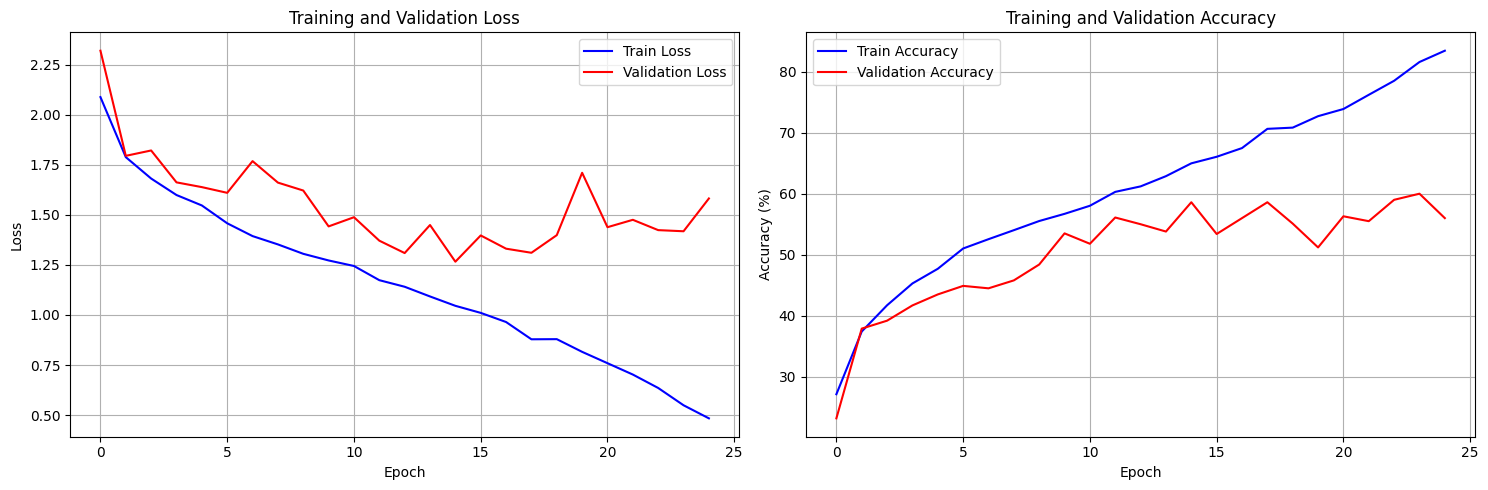

In [120]:
model = SimpleResNet18_33C(num_classes=10)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history_simple_33C = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=25,
    path_model= 'best_model_part_33C.pth'
)

plot_training_history(history_simple_33C)

In [157]:
model = SimpleResNet18_33C(num_classes=10)
params = f'{sum(p.numel() for p in model.parameters())/1000000:.2f}M'
max_val_acc = max(history_simple_33C['val_acc'])
idx = history_simple_33C['val_acc'].index(max_val_acc)
train_acc = history_simple_33C['train_acc'][idx]
epoch = len(history_simple_33C['val_acc'])

df_results.loc[len(df_results)] = ['Model_33C-ELU', params ,epoch, max_val_acc, train_acc, idx + 1]
df_results.head(10)

,model,Количество параметров,Кол-во эпох,Val Accuracy,Train Accuracy,Эпоха по макс Val acc
0,BaseModel,11.17M,25,59.0,98.000,25
1,Model_31A-[32 → 64 → 128 → 256],2.79M,25,62.2,99.850,25
2,Model_31B-[64 → 128 → 256],2.74M,25,61.4,86.075,24
3,"Model_32A-[1,1,1,1]",1.22M,25,60.2,100.000,23
4,"Model_32B-[2,2,2,2]",2.79M,25,62.2,99.850,25
5,"Model_32C-[3,3,3,3]",4.36M,25,60.9,76.525,17
6,Model_33A-ReLU,2.79M,25,62.2,99.850,25
7,Model_33B-LeakyReLU,2.79M,25,60.2,99.650,24
8,Model_33C-ELU,2.79M,25,60.0,81.575,24


### Вариант D: GELU

In [122]:
class SimpleResNet18_33D(nn.Module):
    def __init__(self, num_classes = 10):
        super().__init__()

        self.basic_block_1_1 = BasicBlock(3, 32, activation='gelu')# [32, 64, 64]
        self.basic_block_1_2 = BasicBlock(32, 32, activation='gelu') # [32, 64, 64]

        self.basic_block_2_1 = BasicBlock(32, 64, stride = 2, activation='gelu') # [64, 32, 32]
        self.basic_block_2_2 = BasicBlock(64, 64, activation='gelu') # [64, 32, 32]

        self.basic_block_3_1 = BasicBlock(64, 128, stride = 2, activation='gelu') # [128, 16, 16]
        self.basic_block_3_2 = BasicBlock(128, 128, activation='gelu') # [128, 16, 16]

        self.basic_block_4_1 = BasicBlock(128, 256, stride = 2, activation='gelu') # [256, 8, 8]
        self.basic_block_4_2 = BasicBlock(256, 256, activation='gelu') # [256, 8, 8]

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

        self.fc = nn.Linear(in_features=256, out_features=num_classes)
    
    def forward(self, x):

        x = self.basic_block_1_1(x)
        x = self.basic_block_1_2(x)

        x = self.basic_block_2_1(x)
        x = self.basic_block_2_2(x)

        x = self.basic_block_3_1(x)
        x = self.basic_block_3_2(x)

        x = self.basic_block_4_1(x)
        x = self.basic_block_4_2(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)

        x = self.fc(x)

        return x

Обучение на 25 эпох...
 Эпоха 1/25


Validation: 100%|██████████| 16/16 [00:13<00:00,  1.21it/s, loss=1.77]


 Train Loss: 1.9634, Train Acc: 30.98%
 Val Loss: 2.0041, Val Acc: 32.90%
 Сохранена лучшая модель с точностью 32.90%
 Эпоха 2/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s, loss=1.81]


 Train Loss: 1.7230, Train Acc: 39.85%
 Val Loss: 1.8715, Val Acc: 36.10%
 Сохранена лучшая модель с точностью 36.10%
 Эпоха 3/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.26it/s, loss=1.41]


 Train Loss: 1.5791, Train Acc: 46.25%
 Val Loss: 1.5836, Val Acc: 47.70%
 Сохранена лучшая модель с точностью 47.70%
 Эпоха 4/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s, loss=1.92]


 Train Loss: 1.4597, Train Acc: 50.52%
 Val Loss: 1.8398, Val Acc: 41.20%
 Эпоха 5/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, loss=1.25]


 Train Loss: 1.3770, Train Acc: 53.35%
 Val Loss: 1.4335, Val Acc: 51.30%
 Сохранена лучшая модель с точностью 51.30%
 Эпоха 6/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s, loss=1.34]


 Train Loss: 1.3168, Train Acc: 54.98%
 Val Loss: 1.3262, Val Acc: 56.60%
 Сохранена лучшая модель с точностью 56.60%
 Эпоха 7/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, loss=1.5] 


 Train Loss: 1.1818, Train Acc: 60.58%
 Val Loss: 1.5000, Val Acc: 50.50%
 Эпоха 8/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, loss=1.19] 


 Train Loss: 1.1169, Train Acc: 62.90%
 Val Loss: 1.2346, Val Acc: 59.80%
 Сохранена лучшая модель с точностью 59.80%
 Эпоха 9/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.26it/s, loss=1.43]


 Train Loss: 1.0594, Train Acc: 64.28%
 Val Loss: 1.5043, Val Acc: 52.50%
 Эпоха 10/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.26it/s, loss=1.29]


 Train Loss: 0.9632, Train Acc: 67.72%
 Val Loss: 1.2927, Val Acc: 56.00%
 Эпоха 11/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.26it/s, loss=1.42] 


 Train Loss: 0.8564, Train Acc: 70.97%
 Val Loss: 1.3418, Val Acc: 57.20%
 Эпоха 12/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.28it/s, loss=1.51]


 Train Loss: 0.7690, Train Acc: 73.45%
 Val Loss: 1.4121, Val Acc: 55.60%
 Эпоха 13/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, loss=1.5] 


 Train Loss: 0.6470, Train Acc: 78.62%
 Val Loss: 1.5850, Val Acc: 53.60%
 Эпоха 14/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, loss=1.81]


 Train Loss: 0.5651, Train Acc: 80.72%
 Val Loss: 1.5280, Val Acc: 57.90%
 Эпоха 15/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, loss=2.83]


 Train Loss: 0.4354, Train Acc: 86.10%
 Val Loss: 2.5191, Val Acc: 51.50%
 Эпоха 16/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.26it/s, loss=1.89]


 Train Loss: 0.3289, Train Acc: 89.40%
 Val Loss: 1.5048, Val Acc: 59.00%
 Эпоха 17/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, loss=1.54]


 Train Loss: 0.2252, Train Acc: 92.85%
 Val Loss: 1.5755, Val Acc: 58.50%
 Эпоха 18/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, loss=1.83]


 Train Loss: 0.1376, Train Acc: 96.17%
 Val Loss: 1.8742, Val Acc: 54.30%
 Эпоха 19/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, loss=1.61]


 Train Loss: 0.1355, Train Acc: 96.15%
 Val Loss: 1.7139, Val Acc: 57.80%
 Эпоха 20/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, loss=2.68]


 Train Loss: 0.0923, Train Acc: 97.30%
 Val Loss: 2.2157, Val Acc: 54.90%
 Эпоха 21/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, loss=2.12]


 Train Loss: 0.1157, Train Acc: 96.55%
 Val Loss: 2.2476, Val Acc: 53.20%
 Эпоха 22/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, loss=2.64]


 Train Loss: 0.0884, Train Acc: 97.20%
 Val Loss: 2.0948, Val Acc: 56.90%
 Эпоха 23/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, loss=2.15]


 Train Loss: 0.0395, Train Acc: 99.08%
 Val Loss: 1.9023, Val Acc: 58.00%
 Эпоха 24/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.26it/s, loss=1.64]


 Train Loss: 0.0255, Train Acc: 99.58%
 Val Loss: 1.8538, Val Acc: 58.80%
 Эпоха 25/25


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.27it/s, loss=2.06]

 Train Loss: 0.0173, Train Acc: 99.65%
 Val Loss: 1.7404, Val Acc: 60.10%
 Сохранена лучшая модель с точностью 60.10%


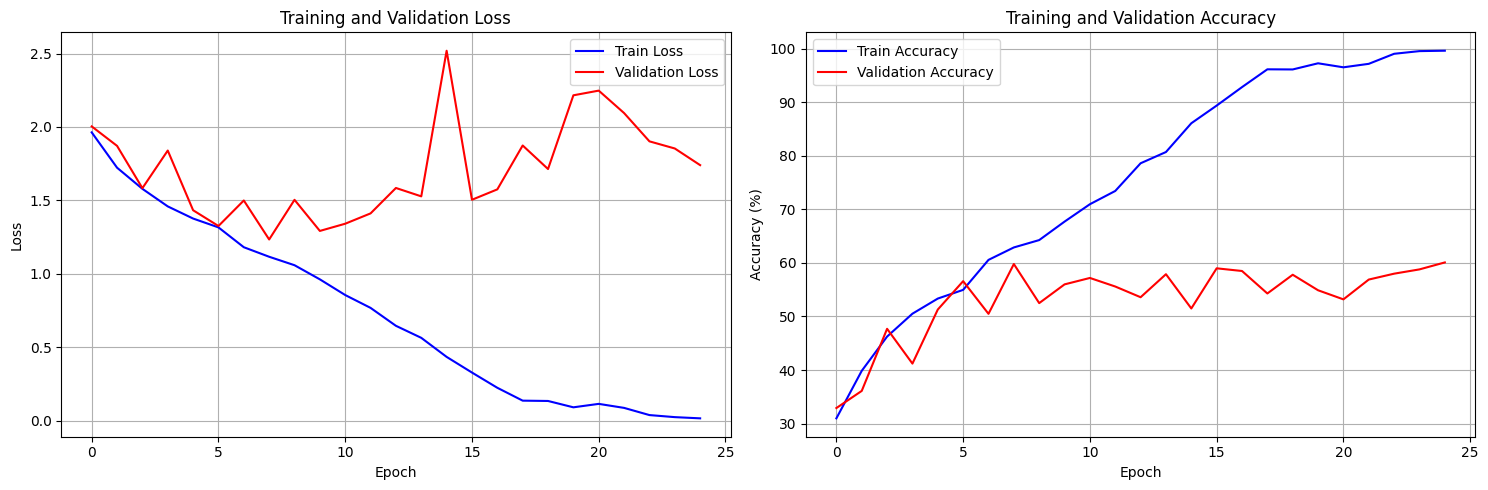

In [123]:
model = SimpleResNet18_33D(num_classes=10)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history_simple_33D = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=25,
    path_model= 'best_model_part_33D.pth'
)

plot_training_history(history_simple_33D)

In [158]:
model = SimpleResNet18_33D(num_classes=10)
params = f'{sum(p.numel() for p in model.parameters())/1000000:.2f}M'
max_val_acc = max(history_simple_33D['val_acc'])
idx = history_simple_33D['val_acc'].index(max_val_acc)
train_acc = history_simple_33D['train_acc'][idx]
epoch = len(history_simple_33D['val_acc'])

df_results.loc[len(df_results)] = ['Model_33D-GELU', params ,epoch, max_val_acc, train_acc, idx + 1]
df_results.head(10)

,model,Количество параметров,Кол-во эпох,Val Accuracy,Train Accuracy,Эпоха по макс Val acc
0,BaseModel,11.17M,25,59.0,98.000,25
1,Model_31A-[32 → 64 → 128 → 256],2.79M,25,62.2,99.850,25
2,Model_31B-[64 → 128 → 256],2.74M,25,61.4,86.075,24
3,"Model_32A-[1,1,1,1]",1.22M,25,60.2,100.000,23
4,"Model_32B-[2,2,2,2]",2.79M,25,62.2,99.850,25
5,"Model_32C-[3,3,3,3]",4.36M,25,60.9,76.525,17
6,Model_33A-ReLU,2.79M,25,62.2,99.850,25
7,Model_33B-LeakyReLU,2.79M,25,60.2,99.650,24
8,Model_33C-ELU,2.79M,25,60.0,81.575,24
9,Model_33D-GELU,2.79M,25,60.1,99.650,25


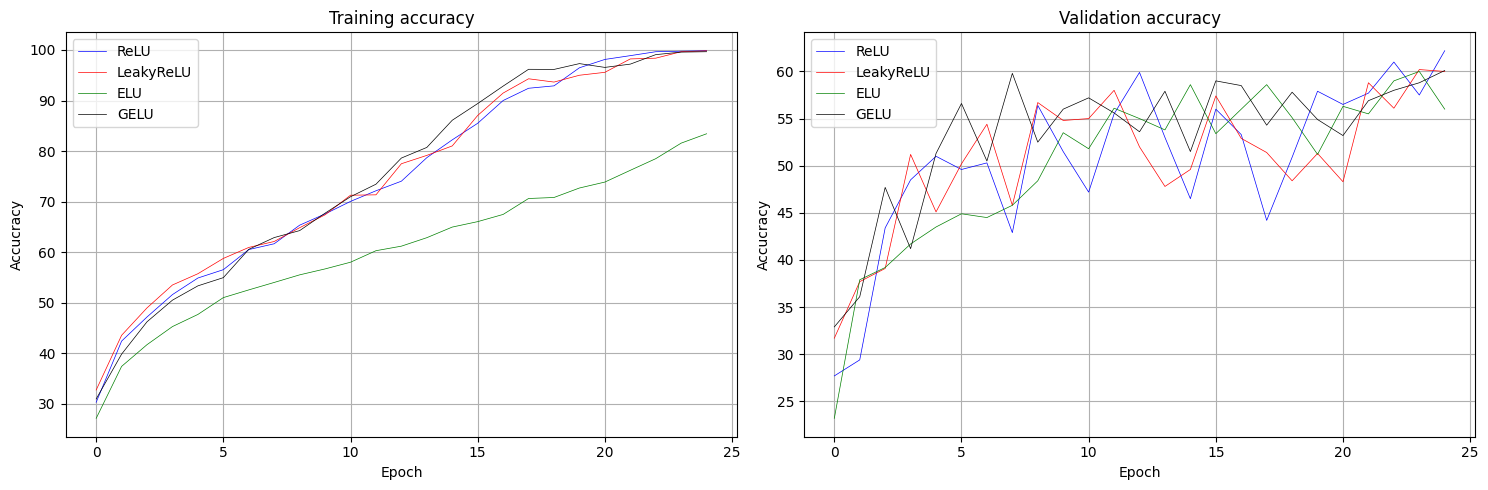

In [126]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


ax1.plot(history_simple_31A['train_acc'], label='ReLU', color='blue', linewidth=0.5)
ax1.plot(history_simple_33B['train_acc'], label='LeakyReLU', color='red', linewidth=0.5)
ax1.plot(history_simple_33C['train_acc'], label='ELU', color='green', linewidth=0.5)
ax1.plot(history_simple_33D['train_acc'], label='GELU', color='black', linewidth=0.5)
ax1.set_title('Training accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accucracy')
ax1.legend()
ax1.grid(True)

ax2.plot(history_simple_31A['val_acc'], label='ReLU', color='blue', linewidth=0.5)
ax2.plot(history_simple_33B['val_acc'], label='LeakyReLU', color='red', linewidth=0.5)
ax2.plot(history_simple_33C['val_acc'], label='ELU', color='green', linewidth=0.5)
ax2.plot(history_simple_33D['val_acc'], label='GELU', color='black', linewidth=0.5)
ax2.set_title('Validation accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accucracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

**Вывод**: В результате эксперимента использования различных функций активации лучшую точность на валидации показала функция активации ReLU. Другие функции активации имею схожую между собой точность на валидации. 

# Часть 4: Финальная модель и тестирование

## 4.1: Создание финальной модели

Обучение на 40 эпох...
 Эпоха 1/40


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validation: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s, loss=1.92]


 Train Loss: 1.9588, Train Acc: 31.90%
 Val Loss: 1.9584, Val Acc: 32.90%
 Сохранена лучшая модель с точностью 32.90%
 Эпоха 2/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.30it/s, loss=1.91]


 Train Loss: 1.6628, Train Acc: 42.48%
 Val Loss: 1.8368, Val Acc: 39.70%
 Сохранена лучшая модель с точностью 39.70%
 Эпоха 3/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.29it/s, loss=1.74]


 Train Loss: 1.5564, Train Acc: 46.42%
 Val Loss: 1.7058, Val Acc: 41.20%
 Сохранена лучшая модель с точностью 41.20%
 Эпоха 4/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.29it/s, loss=1.51]


 Train Loss: 1.4531, Train Acc: 50.62%
 Val Loss: 1.5804, Val Acc: 46.20%
 Сохранена лучшая модель с точностью 46.20%
 Эпоха 5/40


Validation: 100%|██████████| 16/16 [00:13<00:00,  1.19it/s, loss=1.6] 


 Train Loss: 1.3547, Train Acc: 53.50%
 Val Loss: 1.5869, Val Acc: 47.10%
 Сохранена лучшая модель с точностью 47.10%
 Эпоха 6/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=1.64]


 Train Loss: 1.2528, Train Acc: 58.00%
 Val Loss: 1.5584, Val Acc: 51.70%
 Сохранена лучшая модель с точностью 51.70%
 Эпоха 7/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=1.6] 


 Train Loss: 1.1902, Train Acc: 59.90%
 Val Loss: 1.6455, Val Acc: 48.60%
 Эпоха 8/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.30it/s, loss=1.53]


 Train Loss: 1.1342, Train Acc: 61.90%
 Val Loss: 1.4666, Val Acc: 54.00%
 Сохранена лучшая модель с точностью 54.00%
 Эпоха 9/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=1.95]


 Train Loss: 1.0495, Train Acc: 63.85%
 Val Loss: 2.0660, Val Acc: 45.20%
 Эпоха 10/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.30it/s, loss=1.57]


 Train Loss: 0.9606, Train Acc: 67.28%
 Val Loss: 1.4501, Val Acc: 52.00%
 Эпоха 11/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.32it/s, loss=1.76]


 Train Loss: 0.8845, Train Acc: 70.17%
 Val Loss: 1.5420, Val Acc: 51.80%
 Эпоха 12/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.32it/s, loss=1.64]


 Train Loss: 0.8088, Train Acc: 73.15%
 Val Loss: 1.5473, Val Acc: 54.80%
 Сохранена лучшая модель с точностью 54.80%
 Эпоха 13/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=1.62]


 Train Loss: 0.7197, Train Acc: 75.78%
 Val Loss: 1.4180, Val Acc: 58.00%
 Сохранена лучшая модель с точностью 58.00%
 Эпоха 14/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=1.95]


 Train Loss: 0.6075, Train Acc: 79.33%
 Val Loss: 1.4443, Val Acc: 56.30%
 Эпоха 15/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=1.93]


 Train Loss: 0.5200, Train Acc: 82.90%
 Val Loss: 1.6851, Val Acc: 56.00%
 Эпоха 16/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=2.48]


 Train Loss: 0.4216, Train Acc: 85.95%
 Val Loss: 1.9828, Val Acc: 53.70%
 Эпоха 17/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.30it/s, loss=2.74]


 Train Loss: 0.3639, Train Acc: 87.92%
 Val Loss: 2.2461, Val Acc: 47.10%
 Эпоха 18/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=2.2] 


 Train Loss: 0.2835, Train Acc: 90.90%
 Val Loss: 2.1062, Val Acc: 54.90%
 Эпоха 19/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=2.35]


 Train Loss: 0.1958, Train Acc: 93.78%
 Val Loss: 1.7651, Val Acc: 56.50%
 Эпоха 20/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=2.49]


 Train Loss: 0.1192, Train Acc: 96.53%
 Val Loss: 1.8135, Val Acc: 56.90%
 Эпоха 21/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=2.4] 


 Train Loss: 0.0693, Train Acc: 98.28%
 Val Loss: 1.6718, Val Acc: 59.90%
 Сохранена лучшая модель с точностью 59.90%
 Эпоха 22/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.32it/s, loss=2.76]


 Train Loss: 0.0640, Train Acc: 98.25%
 Val Loss: 1.9500, Val Acc: 57.40%
 Эпоха 23/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.32it/s, loss=2.64]


 Train Loss: 0.0621, Train Acc: 98.33%
 Val Loss: 2.1500, Val Acc: 58.30%
 Эпоха 24/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.32it/s, loss=2.13]


 Train Loss: 0.0415, Train Acc: 99.15%
 Val Loss: 1.9048, Val Acc: 59.40%
 Эпоха 25/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=3.25]


 Train Loss: 0.0843, Train Acc: 97.65%
 Val Loss: 3.0618, Val Acc: 45.00%
 Эпоха 26/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=2.68]


 Train Loss: 0.0620, Train Acc: 98.30%
 Val Loss: 2.1136, Val Acc: 55.40%
 Эпоха 27/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=2.56]


 Train Loss: 0.0564, Train Acc: 98.40%
 Val Loss: 2.4154, Val Acc: 53.80%
 Эпоха 28/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=2.43]


 Train Loss: 0.0398, Train Acc: 99.05%
 Val Loss: 2.0447, Val Acc: 59.30%
 Эпоха 29/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=3.2] 


 Train Loss: 0.0416, Train Acc: 98.83%
 Val Loss: 2.7089, Val Acc: 49.70%
 Эпоха 30/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=2.78]


 Train Loss: 0.0437, Train Acc: 98.85%
 Val Loss: 2.1275, Val Acc: 56.20%
 Эпоха 31/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.32it/s, loss=2.69]


 Train Loss: 0.0584, Train Acc: 98.08%
 Val Loss: 2.4715, Val Acc: 56.20%
 Эпоха 32/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=3.05]


 Train Loss: 0.1153, Train Acc: 96.17%
 Val Loss: 2.5627, Val Acc: 52.30%
 Эпоха 33/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=2.87]


 Train Loss: 0.1110, Train Acc: 96.10%
 Val Loss: 2.4955, Val Acc: 52.90%
 Эпоха 34/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=3.44]


 Train Loss: 0.0690, Train Acc: 97.88%
 Val Loss: 2.4128, Val Acc: 56.70%
 Эпоха 35/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=3.04]


 Train Loss: 0.0298, Train Acc: 99.22%
 Val Loss: 2.0679, Val Acc: 60.50%
 Сохранена лучшая модель с точностью 60.50%
 Эпоха 36/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=2.92]


 Train Loss: 0.0139, Train Acc: 99.80%
 Val Loss: 1.9318, Val Acc: 60.60%
 Сохранена лучшая модель с точностью 60.60%
 Эпоха 37/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=2.64]


 Train Loss: 0.0069, Train Acc: 99.88%
 Val Loss: 1.8598, Val Acc: 62.40%
 Сохранена лучшая модель с точностью 62.40%
 Эпоха 38/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=2.51]


 Train Loss: 0.0047, Train Acc: 99.97%
 Val Loss: 1.7763, Val Acc: 64.00%
 Сохранена лучшая модель с точностью 64.00%
 Эпоха 39/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=2.75]


 Train Loss: 0.0022, Train Acc: 100.00%
 Val Loss: 1.8137, Val Acc: 63.80%
 Эпоха 40/40


Validation: 100%|██████████| 16/16 [00:12<00:00,  1.31it/s, loss=2.71]


 Train Loss: 0.0012, Train Acc: 100.00%
 Val Loss: 1.7934, Val Acc: 64.10%
 Сохранена лучшая модель с точностью 64.10%


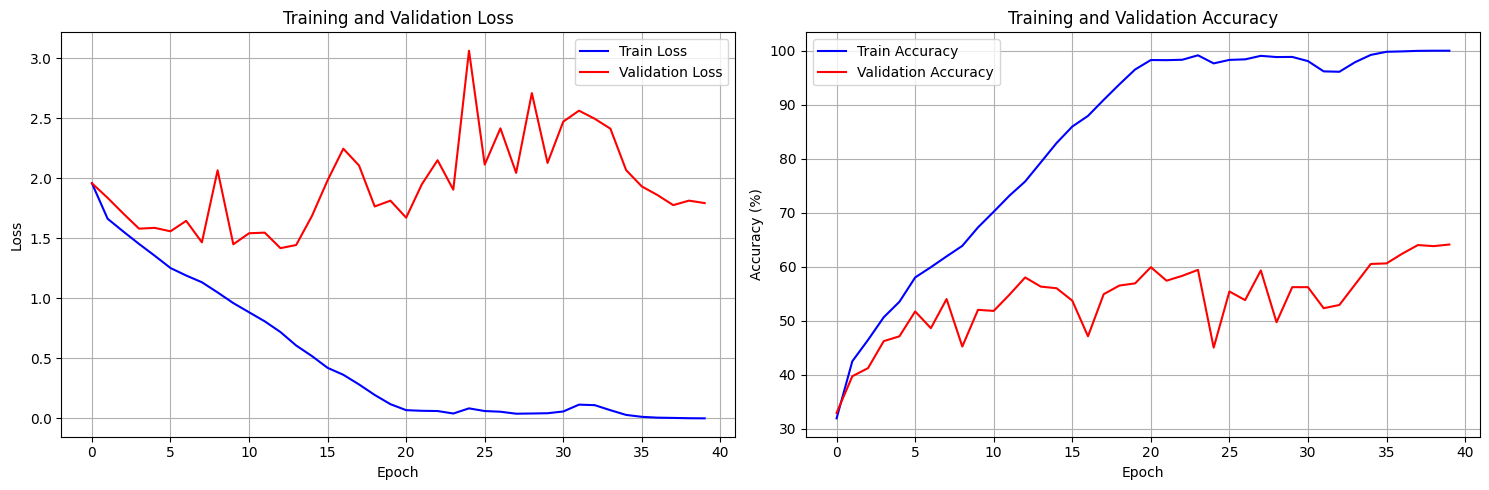

In [134]:
model = SimpleResNet18_31A(num_classes=10)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

history_result = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=40,
    path_model= 'result_model.pth'
)

plot_training_history(history_result)

In [159]:
model = SimpleResNet18_31A(num_classes=10)
params = f'{sum(p.numel() for p in model.parameters())/1000000:.2f}M'
max_val_acc = max(history_result['val_acc'])
idx = history_result['val_acc'].index(max_val_acc)
train_acc = history_result['train_acc'][idx]
epoch = len(history_result['val_acc'])

df_results.loc[len(df_results)] = ['[32→64→128→256]-[2,2,2,2]-ReLU', params ,epoch, max_val_acc, train_acc, idx + 1]
df_results.head(11)

,model,Количество параметров,Кол-во эпох,Val Accuracy,Train Accuracy,Эпоха по макс Val acc
0,BaseModel,11.17M,25,59.0,98.000,25
1,Model_31A-[32 → 64 → 128 → 256],2.79M,25,62.2,99.850,25
2,Model_31B-[64 → 128 → 256],2.74M,25,61.4,86.075,24
3,"Model_32A-[1,1,1,1]",1.22M,25,60.2,100.000,23
4,"Model_32B-[2,2,2,2]",2.79M,25,62.2,99.850,25
5,"Model_32C-[3,3,3,3]",4.36M,25,60.9,76.525,17
6,Model_33A-ReLU,2.79M,25,62.2,99.850,25
7,Model_33B-LeakyReLU,2.79M,25,60.2,99.650,24
8,Model_33C-ELU,2.79M,25,60.0,81.575,24
9,Model_33D-GELU,2.79M,25,60.1,99.650,25


## 4.2: Тестирование на test set

In [262]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

In [263]:
selected_classes = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27]  # 10 классов
selected_wnids = [train_dataset.class_names[clas] for clas in selected_classes]

In [264]:
with open(os.path.join(root, 'words.txt'), 'r') as f:
    wnid_word = {}
    for line in f:
        wnid, word = line.strip().split('\t', 1)
        wnid_word[wnid] = word

class_names = [wnid_word[wnid].split(",")[0] for wnid in selected_wnids]
print(class_names)

['Egyptian cat', 'rocking chair', 'basketball', 'plunger', 'dining table', 'school bus', 'umbrella', 'maypole', 'hourglass', 'Arabian camel']


In [265]:
res_preds = []
res_labels = []

result_model = SimpleResNet18_31A(num_classes=10)
result_model.load_state_dict(torch.load('result_model.pth'))
result_model = result_model.to(device)
result_model.eval()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = result_model(data)
        _, preds = torch.max(output, 1)

        res_preds.extend(preds.cpu().numpy())
        res_labels.extend(target.cpu().numpy())
        

In [266]:
acc = accuracy_score(res_labels, res_preds)

precision, recall, f1, _ = precision_recall_fscore_support(
    res_labels, res_preds, average=None, zero_division=0
)

print(f"Test Accuracy: {acc:.4f}")
print("\nPer-class metrics:")
for i in range(len(class_names)):
    print(f"Class {class_names[i]:30}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}")

Test Accuracy: 0.6920

Per-class metrics:
Class Egyptian cat                  : Precision=0.6727, Recall=0.7400, F1=0.7048
Class rocking chair                 : Precision=0.5741, Recall=0.6200, F1=0.5962
Class basketball                    : Precision=0.8222, Recall=0.7400, F1=0.7789
Class plunger                       : Precision=0.5556, Recall=0.4000, F1=0.4651
Class dining table                  : Precision=0.6923, Recall=0.7200, F1=0.7059
Class school bus                    : Precision=0.9167, Recall=0.8800, F1=0.8980
Class umbrella                      : Precision=0.5294, Recall=0.5400, F1=0.5347
Class maypole                       : Precision=0.7213, Recall=0.8800, F1=0.7928
Class hourglass                     : Precision=0.6735, Recall=0.6600, F1=0.6667
Class Arabian camel                 : Precision=0.7551, Recall=0.7400, F1=0.7475


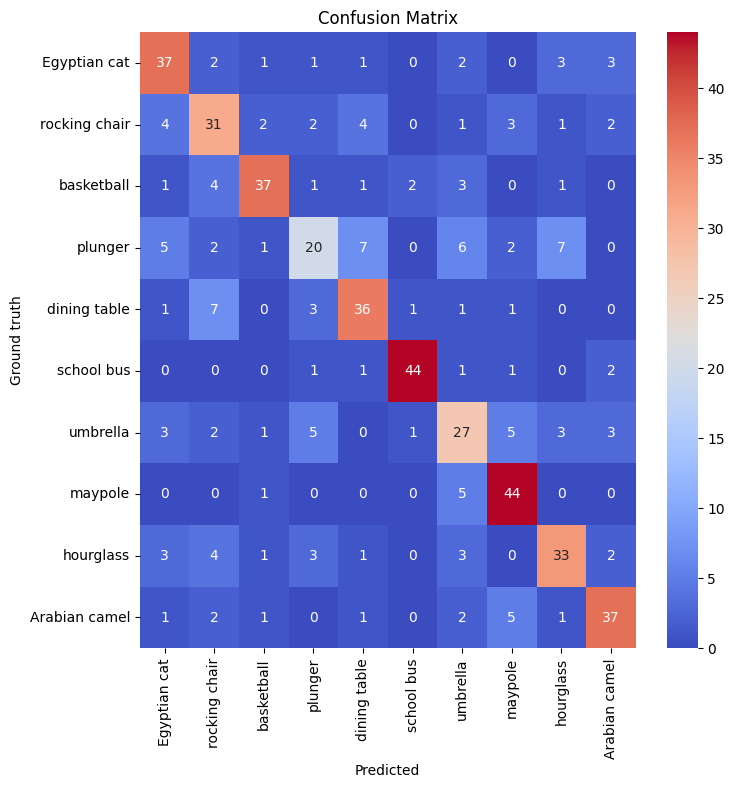

In [267]:
conf_matr= confusion_matrix(res_labels, res_preds)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matr, annot=True,cmap='coolwarm',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Ground truth')
plt.show()

## 4.3: Визуальный анализ

In [268]:
indices = np.random.choice(len(test_subset_dataset), size=10, replace=False)

sample_images = []
sample_gt_labels = []
sample_pred_labels = []

with torch.no_grad():
    for idx in indices:
        data, target = test_subset_dataset[idx]
        sample_images.append(data)
        sample_gt_labels.append(target)

        output = result_model(data.unsqueeze(0).to(device))
        pred = torch.argmax(output, dim=1).item()
        sample_pred_labels.append(pred)

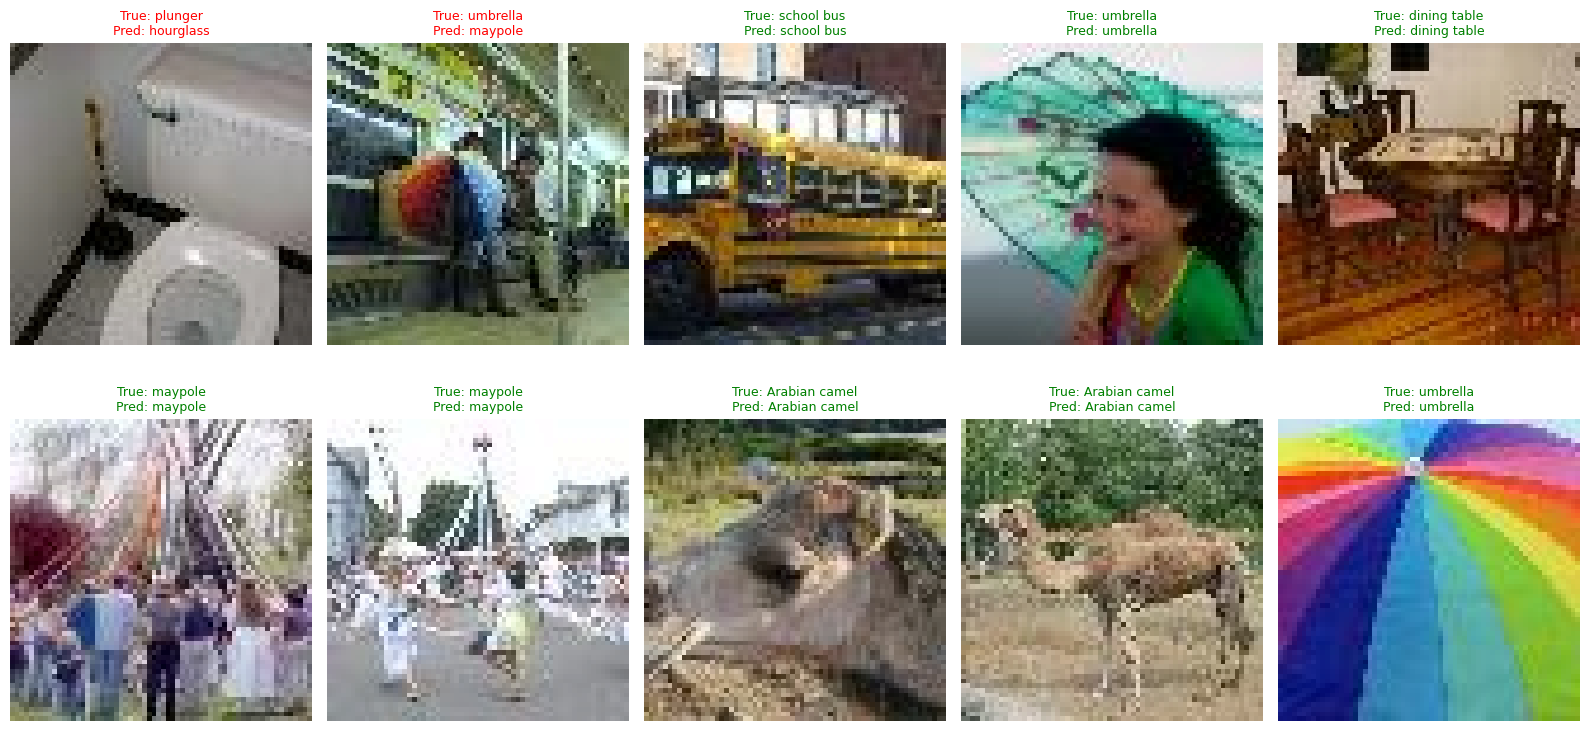

In [269]:
fig, axes = plt.subplots(2, 5, figsize=(16, 8))
axes = axes.ravel()

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)


for i in range(10):
    ax = axes[i]
    img = sample_images[i]
    img = inv_normalize(img)
    img = torch.clamp(img, 0, 1)
    img = img.permute(1, 2, 0).numpy()

    ax.imshow(img)
    gt_cls = sample_gt_labels[i]
    pred_cls = sample_pred_labels[i]
    color = 'green' if gt_cls == pred_cls else 'red'
    true_name = class_names[gt_cls]
    pred_name = class_names[pred_cls]
    ax.set_title(f"True: {true_name}\nPred: {pred_name}", color=color, fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 4.4: Сравнительная таблица всех экспериментов

In [270]:
df_results.head(11)

,model,Количество параметров,Кол-во эпох,Val Accuracy,Train Accuracy,Эпоха по макс Val acc
0,BaseModel,11.17M,25,59.0,98.000,25
1,Model_31A-[32 → 64 → 128 → 256],2.79M,25,62.2,99.850,25
2,Model_31B-[64 → 128 → 256],2.74M,25,61.4,86.075,24
3,"Model_32A-[1,1,1,1]",1.22M,25,60.2,100.000,23
4,"Model_32B-[2,2,2,2]",2.79M,25,62.2,99.850,25
5,"Model_32C-[3,3,3,3]",4.36M,25,60.9,76.525,17
6,Model_33A-ReLU,2.79M,25,62.2,99.850,25
7,Model_33B-LeakyReLU,2.79M,25,60.2,99.650,24
8,Model_33C-ELU,2.79M,25,60.0,81.575,24
9,Model_33D-GELU,2.79M,25,60.1,99.650,25


**Вывод**: В результате проведенных экспериментов лучшей архитектурой является использование [2,2,2,2] residual блоков с каналами [32 → 64 → 128 → 256] и функцией активаиции - ReLU.

Стоит омтетить, что разница между обучающей и валидационной выборкой составляет порядка 0.36 (36%), что является признаком переобучения модели.